In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import duckdb
from mriomain import mrio

In [2]:
input_mrio = '../data/mrio.parquet'
input_ee = '../data/ee.parquet'
countries_mapping = pd.read_excel('../data/raw/countries.xlsx')
sectors_mapping = pd.read_csv('../data/raw/sectors.csv')

years = [2017, 2018, 2019, 2020, 2021]

## Industrial Sectors

_**Carbon leakage**_: Transfer of emissions from one jurisdiction to another due to the implementation of climate policies to regulate certain sectors
- Effect: <u>reduced competitiveness</u> of domestic sectors <u>without achieving mitigation objectives</u> (on a global perspective)
- In some jurisdictions, governments are reluctant to introduce carbon pricing schemes (where sectors incur additional cost proportional to emissions) or certain sectors are exempted out of mitigation policies due to risk of carbon leakage
- Relevance: understanding carbon leakage risk in industrial sectors informs climate policies (e.g. sectors with low leakage risk can be included in mitigation efforts, anti-leakage mechanisms can be established for sectors with high carbon leakage risk)

**Objectives**

1. Defining emission intensity and trade exposure of industrial sectors
2. Quantifying carbon leakage risk


### A. Emission Impact Ratio (EIR)
Volume of a country-sector's GHG emissions (direct + indirect) / country-sector's GVA
* *EIR Direct* - emissions resulting from a country-sector's production / country-sector's GVA
* *EIR Indirect* - emissions resulting from the production of a country-sector's inputs / country-sector's GVA

In [3]:
sectors_mapping

,c_ind,c_name,c_name_short,c_abv,c15_ind,c15_name,c5_ind,c5_name
0,1,"Agriculture, hunting, forestry and fishing",Agriculture,AHF,1,"Agriculture, hunting, forestry, and fishing",1,Primary
1,2,Mining and quarrying,Mining,MIN,2,Mining and quarrying,1,Primary
2,3,"Food, beverages and tobacco",Food & beverages,FBT,3,Light manufacturing,2,Low-technology manufacturing
3,4,Textiles and textile products,Textiles,TEX,3,Light manufacturing,2,Low-technology manufacturing
4,5,"Leather, leather products and footwear",Leather,LTH,3,Light manufacturing,2,Low-technology manufacturing
5,6,Wood and products of wood and cork,Wood,WDC,3,Light manufacturing,2,Low-technology manufacturing
6,7,"Pulp, paper, printing and publishing",Paper,PPP,3,Light manufacturing,2,Low-technology manufacturing
7,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,CRP,4,Heavy manufacturing,3,Medium- to high-technology manufacturing
8,9,Chemicals and chemical products,Chemicals,CCP,4,Heavy manufacturing,3,Medium- to high-technology manufacturing
9,10,Rubber and plastics,Rubber,RBP,3,Light manufacturing,2,Low-technology manufacturing


In [4]:
# column labels
df = duckdb.sql(f"SELECT * FROM '{input_ee}'").df()
labels = df.columns[4:2559].to_frame(index=False)[0].str.split("_", expand=True)
labels = labels.set_axis(['country', 'mrio_sector'], axis=1)

# mapping: ghg sectors
ghg_sectors = sorted(df['sector'].unique().tolist())

# mapping: mrio sectors
sectors_map = sectors_mapping.iloc[:, 0:3]
sectors_map['mrio_sector'] = 'c' + sectors_map['c_ind'].astype(str)
sectors_map = sectors_map.rename(columns={'c_ind': 'sector_no', 'c_name': 'sector_name', 'c_name_short': 'sector_name_short'})
agg_map = sectors_mapping.iloc[:, [0, 5]]

# mapping: regions
region_map = countries_mapping.iloc[:, [8,12]]

# industrial sectors 
ind_sectors = [f"c{i}" for i in range(3, 16+1)]

In [5]:
# process emissions data
def get_emdf(by=None):

    dfs = []
    for year in years: 
        data_ee = mrio.EE(f'{input_ee}', year, by)
        data_mrio = mrio.MRIO(f'{input_mrio}', year, full=True)

        # direct emissions
        direct = data_ee.E

        # indirect emissions
        e = data_ee.E @ (1/data_mrio.x).diag()
        B = data_mrio.B
        Z = data_mrio.Z
        indirect = (e @ B) @ Z

        # total emissions
        total = direct + indirect

        # gva
        gva = data_mrio.va
        gva = np.array(gva.data.tolist())

        # for aggregated data
        if by == None:
            emissions_dict = {
                'year': year,
                'direct': direct.data.tolist()[0],
                'indirect': indirect.data.tolist()[0],
                'total': total.data.tolist()[0],
                'gva': gva.tolist()
            } 
            temp_df = pd.concat([labels, pd.DataFrame.from_dict(emissions_dict)], axis=1)
        
        # for sector data 
        elif by == 'sector':
            sec_dfs = []    
            for i, sector in enumerate(ghg_sectors):
                emissions_dict = {
                    'year': year,
                    'ipcc_sector': sector,
                    'direct': direct.data.tolist()[i],
                    'indirect': indirect.data.tolist()[i],
                    'total': total.data.tolist()[i],
                    'gva': gva.tolist()
                }
                sec_df = pd.concat([labels, pd.DataFrame.from_dict(emissions_dict)], axis=1)
                sec_dfs.append(sec_df)  
                temp_df = pd.concat(sec_dfs, ignore_index=True)

        # compute emission impact ratios
        temp_df['d_eir'] = temp_df['direct'] / temp_df['gva']
        temp_df['i_eir'] = temp_df['indirect'] / temp_df['gva']
        temp_df['eir'] = temp_df['total'] / temp_df['gva']

        # add sector name and region
        temp_df = pd.merge(temp_df, sectors_map, on='mrio_sector')
        temp_df = pd.merge(temp_df, region_map, left_on='country', right_on='code').drop(columns=['code'])
        
        # combine dfs 
        dfs.append(temp_df)
        
    em_df = pd.concat(dfs, ignore_index=True)
    return em_df

In [6]:
# main dfs
em_df_total = get_emdf()
em_df_sector = get_emdf(by='sector')

In [ ]:
# industry df 
industry_em = em_df_total[em_df_total['mrio_sector'].isin(ind_sectors)].copy()
industry_em

In [16]:
industry_em[industry_em['d_eir'] == np.inf]

,country,mrio_sector,year,direct,indirect,total,gva,d_eir,i_eir,eir,sector_no,sector_name,sector_name_short,region
2317,ARM,c8,2017,16.161412,0.0,16.161412,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
4872,ARM,c8,2018,11.617429,0.0,11.617429,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
7427,ARM,c8,2019,8.429720,0.0,8.429720,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
9982,ARM,c8,2020,12.383702,0.0,12.383702,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
12537,ARM,c8,2021,12.383702,0.0,12.383702,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia


In [17]:
# ipcc df
ipcc_df = (em_df_sector[em_df_sector['mrio_sector'].isin(ind_sectors)].copy()
           .drop(columns=['mrio_sector'])
           .groupby(['country', 'region', 'year', 'ipcc_sector'])
           .agg('sum')
           .reset_index()
           )

##### A.1 Country: EIR of industrial sectors, 2021

In [9]:
# EIR country aggregates
eir_agg = (
    em_df_total[['country', 'year', 'direct', 'indirect', 'total', 'gva', 'region']]
    .groupby(['country', 'year', 'region']).agg('sum')
    .reset_index()
)
eir_agg['d_eir'] = eir_agg['direct'] / eir_agg['gva']
eir_agg['i_eir'] = eir_agg['indirect'] / eir_agg['gva']
eir_agg['eir'] = eir_agg['total'] / eir_agg['gva']

# EIR by year
eir_2021 = eir_agg[eir_agg['year'] == 2021]

In [ ]:
eir_2021.to_excel('../data/dfs/plot1.xlsx')

In [19]:
eir_2021[eir_2021['country'].isin(['NEP', 'MON', 'BHU'])]

,country,year,region,direct,indirect,total,gva,d_eir,i_eir,eir
39,BHU,2021,South Asia,1113.859261,324.148911,1438.008173,153.435176,7.259478,2.112611,9.372089
229,MON,2021,East Asia and Pacific,2046.520962,14948.675067,16995.196030,1238.074163,1.652987,12.074135,13.727123
234,NEP,2021,South Asia,7490.592767,8696.830211,16187.422978,2071.597253,3.615854,4.198128,7.813982


In [70]:
# chart settings
plt.rcParams['font.family'] = 'Arial'

region_colors = {
    'East Asia and Pacific': '#007db7',
    'Europe and Central Asia': '#8dc63f', 
    'Latin America and the Caribbean': '#e9532b',
    'Middle East and North Africa': '#f2e600',
    'North America': '#f57f29',
    'South Asia': '#6dcff6',
}
mapped_colors = [region_colors[region] for region in eir_2021.region]


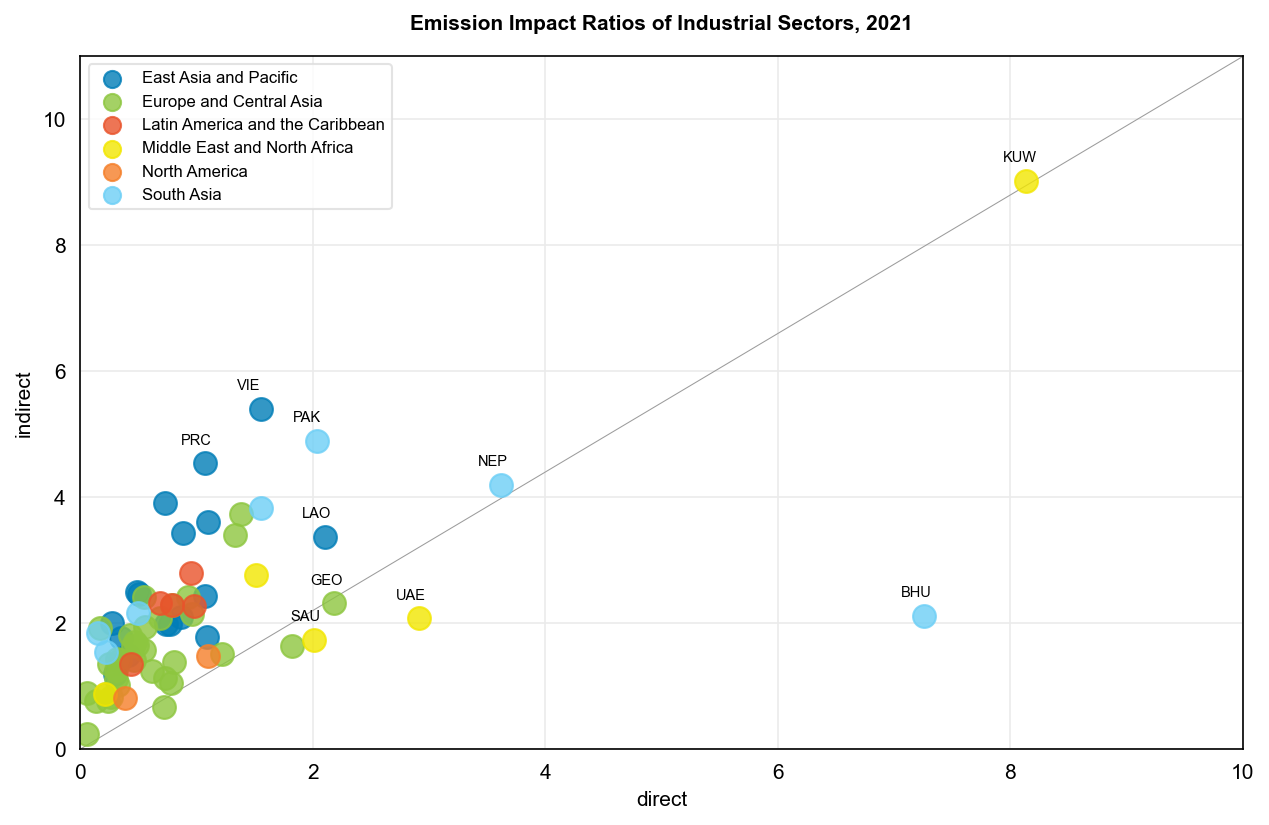

In [25]:
plt.figure(figsize=(10, 6), dpi=150, edgecolor='#EBEBEB')
plt.plot([0, eir_2021['i_eir'].max()], [0, eir_2021['i_eir'].max()+1.2], color='#9C9C9C', linewidth=0.5)
for region, color in region_colors.items():
    region_data = eir_2021[eir_2021['region'] == region]
    plt.scatter(x=region_data['d_eir'], 
                y=region_data['i_eir'], 
                c=color, s=120, alpha=0.8, 
                label=region, zorder=2)

for i, (x, y) in enumerate(zip(eir_2021.d_eir, eir_2021.i_eir)):
    if x > 2 or y > 4:
        plt.annotate(eir_2021.country.iloc[i], (x-0.2, y+0.3), fontsize=7)

plt.grid(color='#EBEBEB') 
plt.xlim((0,10))
plt.ylim((0,11))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('direct', fontsize=10)
plt.ylabel('indirect', fontsize=10)
plt.title('Emission Impact Ratios of Industrial Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='upper left')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 01.pdf')
plt.show()

##### A.2 Country: EIR of industrial sectors, 2021

In [12]:
# EIR by country (Asia)
ei_asia = eir_2021[eir_2021['region'].isin(['East Asia and Pacific', 'Europe and Central Asia', 'South Asia'])]

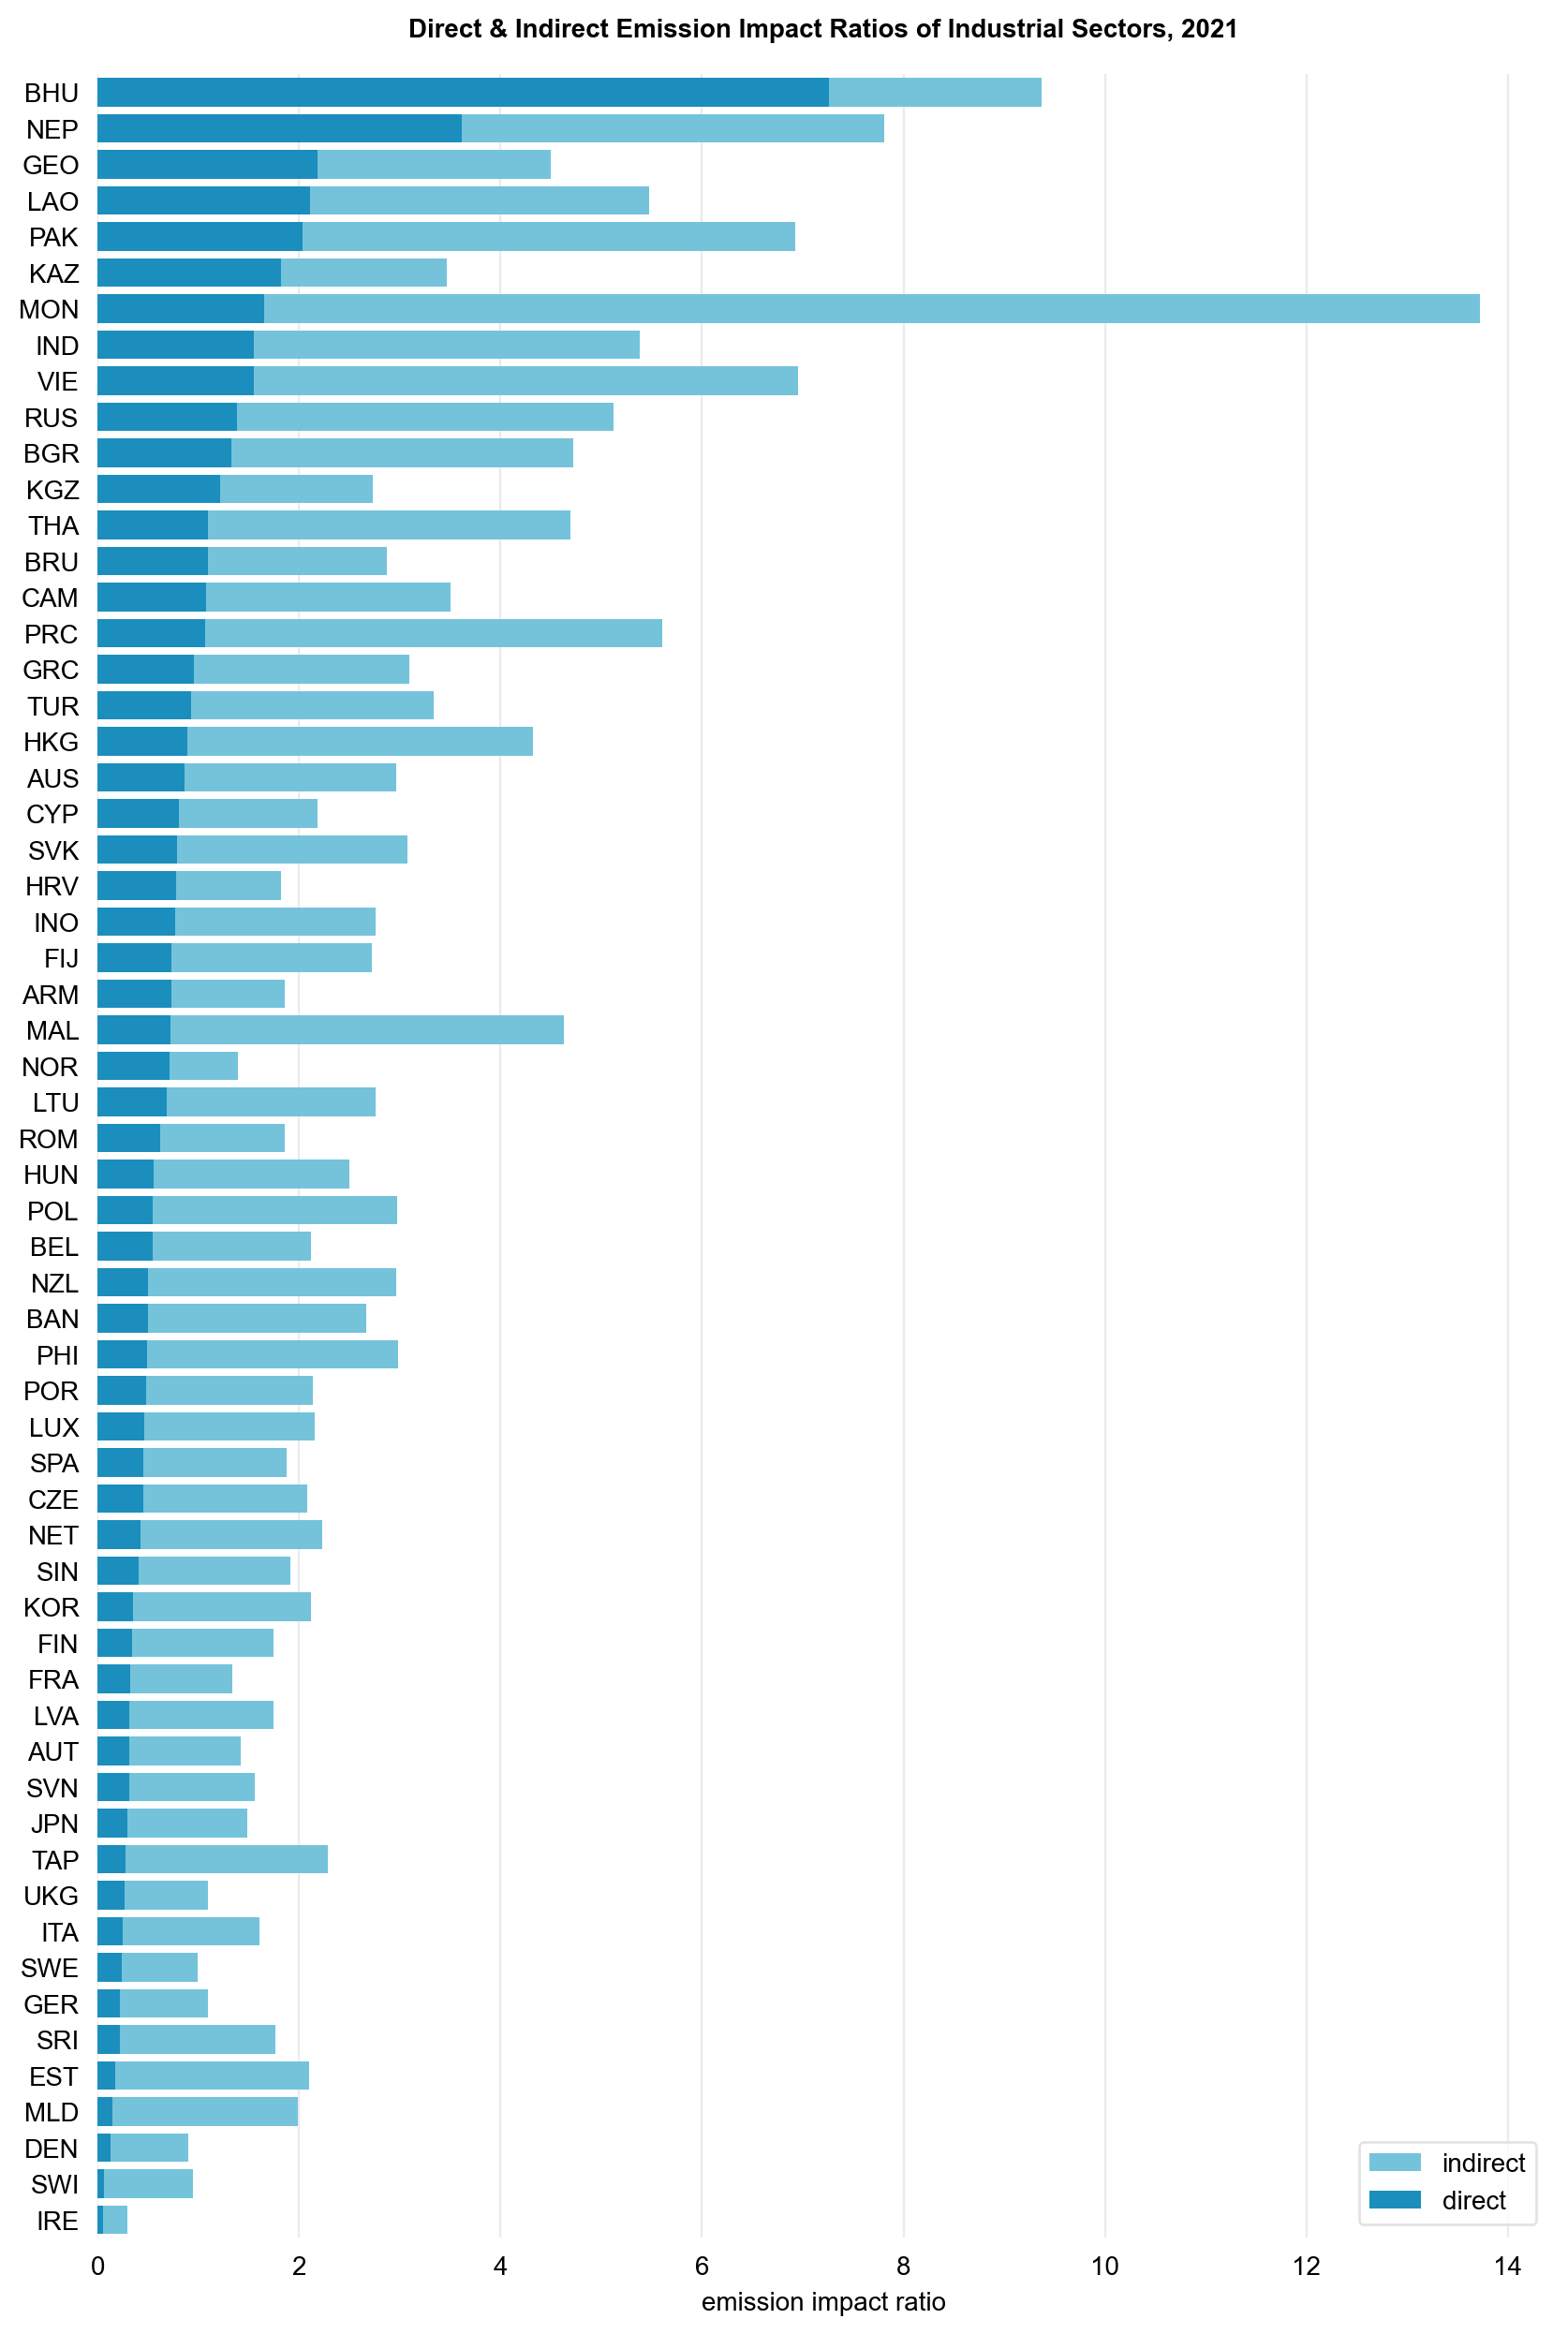

In [498]:
ordered_df = ei_asia.sort_values(by='d_eir', ascending=False)
left_positions = ordered_df["d_eir"].values

f, ax = plt.subplots(figsize=(10, 15), dpi=200)
sns.barplot(x="i_eir", y="country", data=ordered_df, label="indirect", 
            color="#63ccec", errorbar=None, left=left_positions, zorder=2)
sns.barplot(x="d_eir", y="country", data=ordered_df, label="direct", 
            color="#0099d8", errorbar=None, zorder=2)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Direct & Indirect Emission Impact Ratios of Industrial Sectors, 2021', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
sns.despine(left=True, bottom=True)

plt.savefig('../charts/plot 02.png')
plt.show()

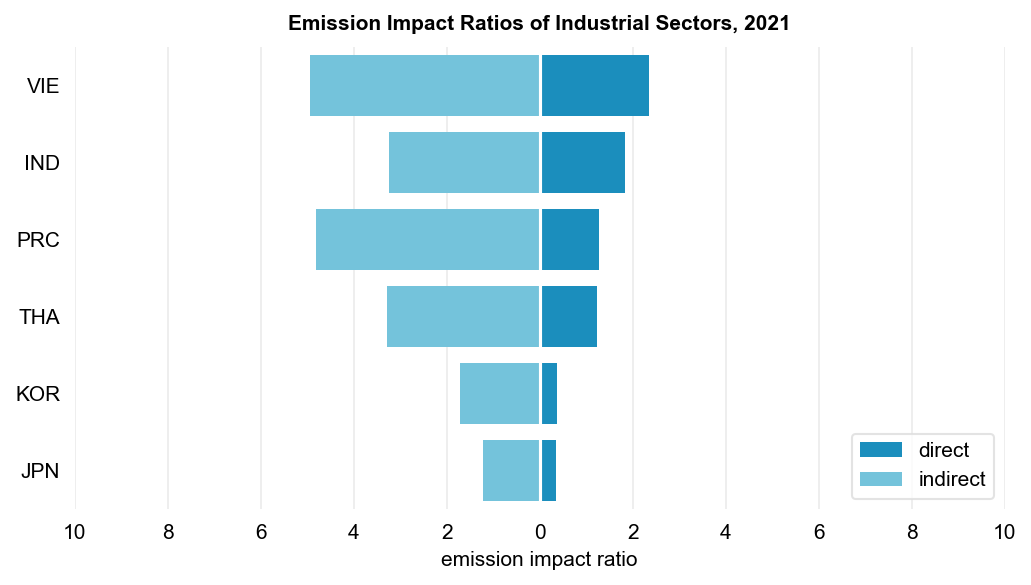

In [394]:
ordered_df = (
    ei_asia[ei_asia['country'].isin(['PRC', 'KOR', 'JPN', 'IND', 'VIE', 'THA'])]
    .sort_values(by='d_eir', ascending=False)
              )

positive_values = ordered_df["d_eir"].values
negative_values = -ordered_df["i_eir"].values

f, ax = plt.subplots(figsize=(8, 4), dpi=150)

sns.barplot(x=positive_values, y="country", data=ordered_df, color="#0099d8", label="direct", ax=ax, zorder=2)
sns.barplot(x=negative_values, y="country", data=ordered_df, color="#63ccec", label="indirect", ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 
xticks = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
xticklabels = [f"{abs(val):.0f}" for val in xticks]
plt.xticks(xticks, xticklabels, fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Emission Impact Ratios of Industrial Sectors, 2021', y=1.01, fontsize=10, fontweight='bold')

legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)
plt.savefig('../charts/plot 03.png')
plt.show()


##### A.3 Country: EIR 2017, 2019, 2021

In [13]:
eir_total = eir_agg[['country', 'year', 'region', 'd_eir', 'i_eir', 'eir']]
eir_total = eir_total[(eir_total['year'].isin([2017, 2019,2021])) & 
                    (eir_total['region'] == 'East Asia and Pacific')]
eir_total = eir_total.pivot(index=['country', 'region'], columns='year', values='eir').reset_index()

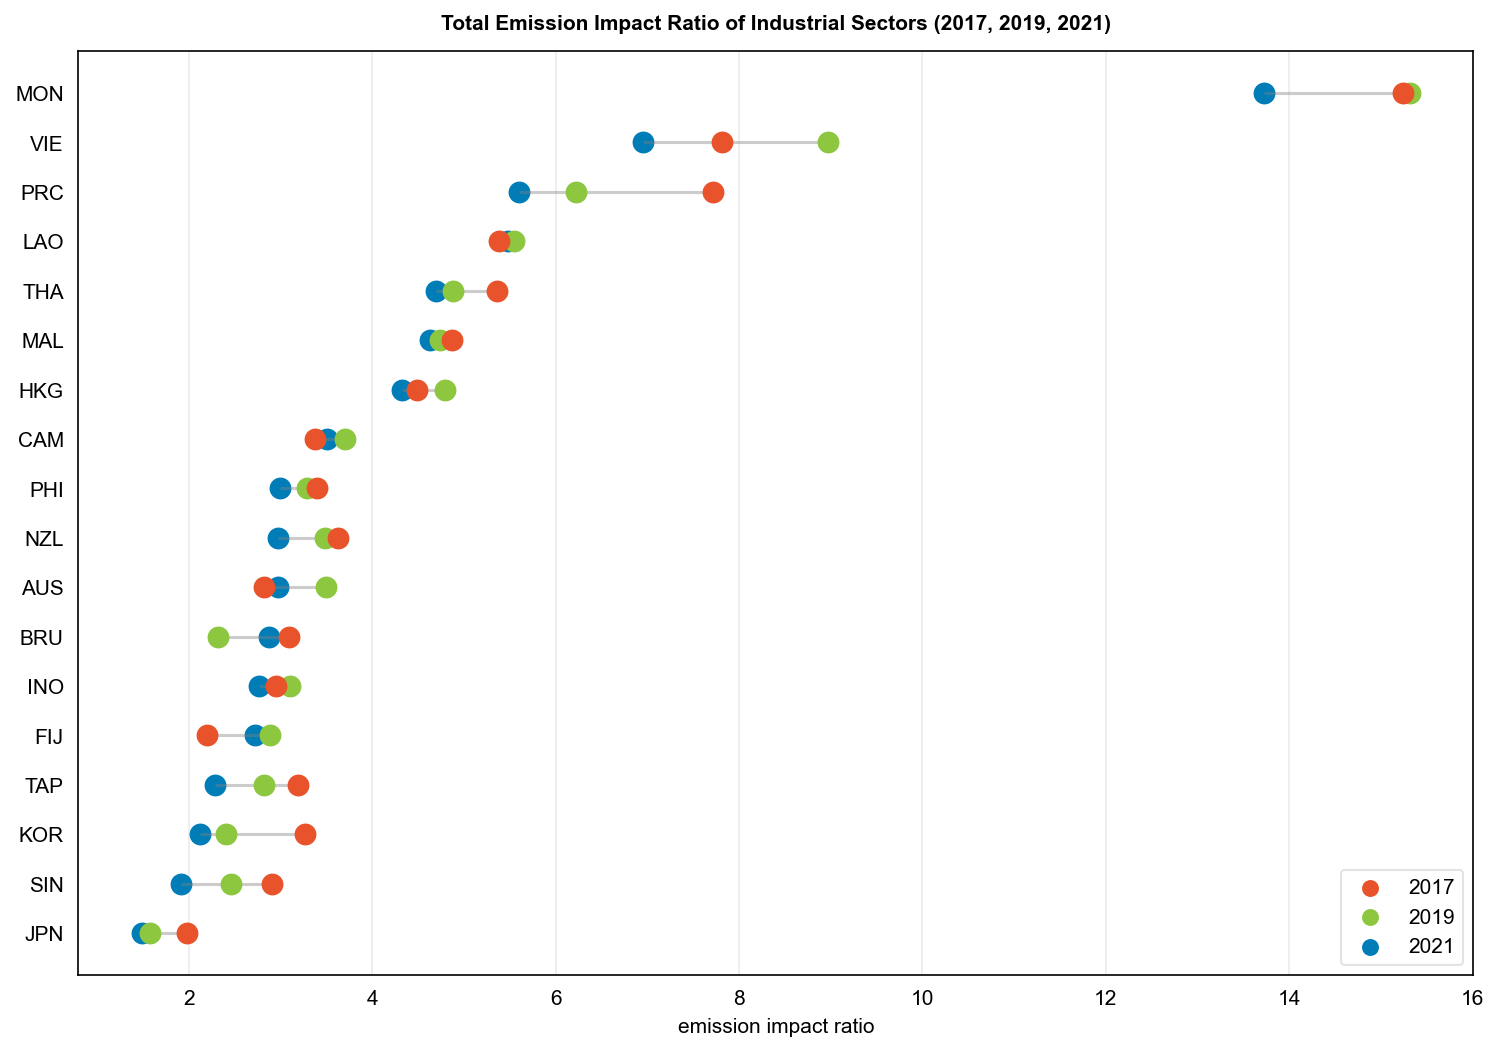

In [237]:
ordered_df = eir_total.sort_values(by=2021)

plt.figure(figsize=(12, 8), dpi=150, edgecolor='#EBEBEB')

plt.scatter(x=ordered_df[2017], y=ordered_df['country'], color='#e9532b', alpha=1, label='2017', s=90, zorder=4)
plt.scatter(x=ordered_df[2019], y=ordered_df['country'], color='#8dc63f', alpha=1, label='2019', s=90, zorder=3)
plt.scatter(x=ordered_df[2021], y=ordered_df['country'], color='#007db7', alpha=1, label='2021', s=90, zorder=2)

min_val = ordered_df[[2017, 2019, 2021]].min(axis=1)
max_val = ordered_df[[2017, 2019, 2021]].max(axis=1)
plt.hlines(y=ordered_df['country'], xmin=min_val, xmax=max_val, color='grey', alpha=0.4)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10, y=-1.01)
plt.ylabel('')
plt.title('Total Emission Impact Ratio of Industrial Sectors (2017, 2019, 2021)', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 04.png')
plt.show()

##### A.4 Sector: EIR by industrial sector

In [26]:
eir_sector = industry_em[industry_em['gva'] >0]
eir_sector = (
    eir_sector[['mrio_sector', 'sector_name', 'sector_name_short', 'year', 'd_eir', 'i_eir', 'eir']]
    .groupby(['mrio_sector', 'sector_name', 'sector_name_short', 'year']).agg('mean').reset_index()
    )

In [28]:
eir_sector.to_excel('../data/dfs/plot2.xlsx')

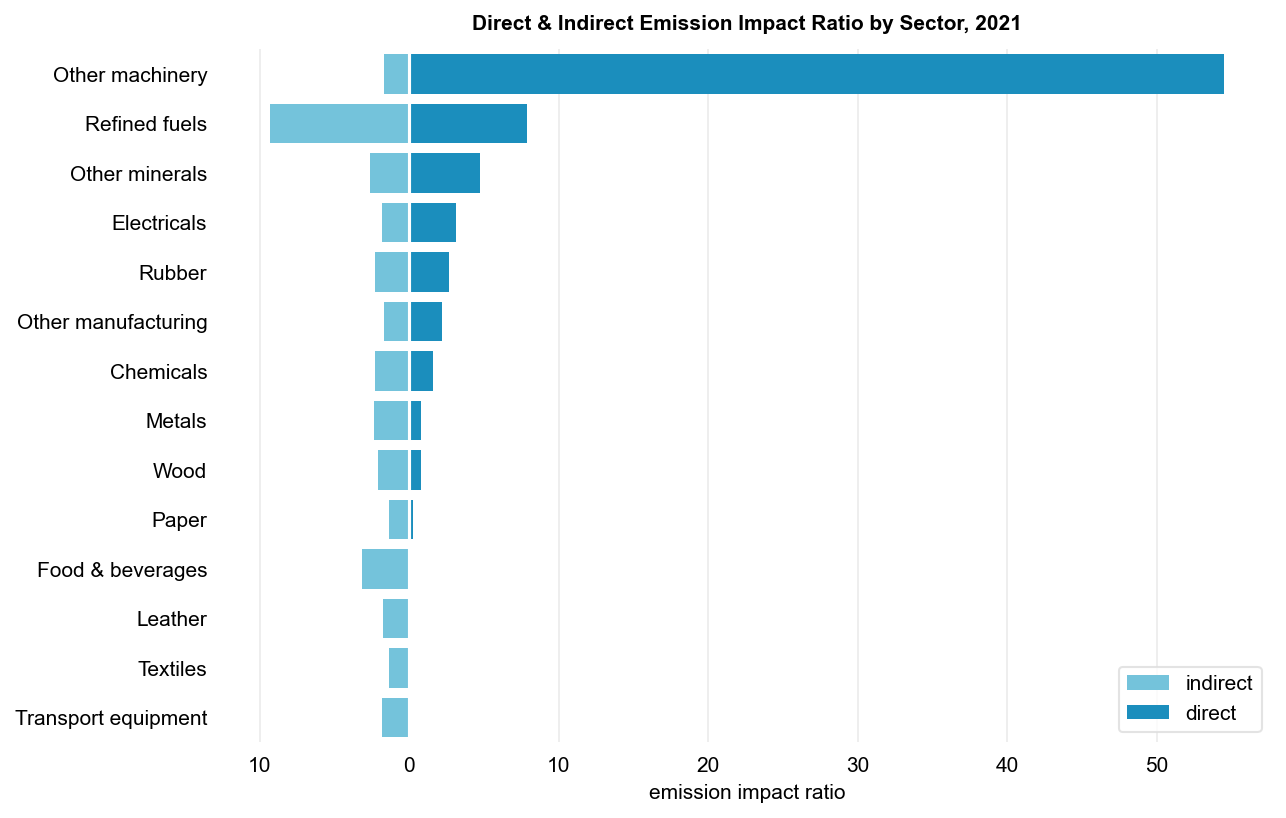

In [29]:
ordered_df = (
    eir_sector[(eir_sector['year'] == 2021)]
    .sort_values(by='d_eir', ascending=False)
)

positive_values = ordered_df["d_eir"].values
negative_values = -ordered_df["i_eir"].values

f, ax = plt.subplots(figsize=(10, 6), dpi=150)

sns.barplot(x=negative_values, y="sector_name_short", data=ordered_df, color="#63ccec", label="indirect", ax=ax, zorder=2)
sns.barplot(x=positive_values, y="sector_name_short", data=ordered_df, color="#0099d8", label="direct", ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 

xticks = [-10, 0, 10, 20, 30, 40, 50]
xticklabels = [f"{abs(val):.0f}" for val in xticks]
plt.xticks(xticks, xticklabels, fontsize=10)
ax.set_yticks(np.arange(len(ordered_df)))
plt.yticks(fontsize=10)

plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Direct & Indirect Emission Impact Ratio by Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.subplots_adjust(left=0.2)

legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)

plt.savefig('../charts/plot 05.pdf')
plt.show()

##### A.5 Sector: EIR by IPCC sector

In [15]:
eir_ipcc = em_df_sector[em_df_sector['gva'] >0]
eir_ipcc = (
    eir_ipcc[['sector_no', 'mrio_sector', 'sector_name', 'sector_name_short', 'ipcc_sector', 'year', 'd_eir', 'i_eir', 'eir']]
    .groupby(['sector_no', 'mrio_sector', 'sector_name', 'sector_name_short', 'ipcc_sector', 'year']).agg('mean').reset_index()
    )

In [500]:
df_heatmap = (
    eir_ipcc[(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='eir',index=['sector_no', 'sector_name'],columns='ipcc_sector',aggfunc='mean')
    .sort_values(by='sector_no')
)

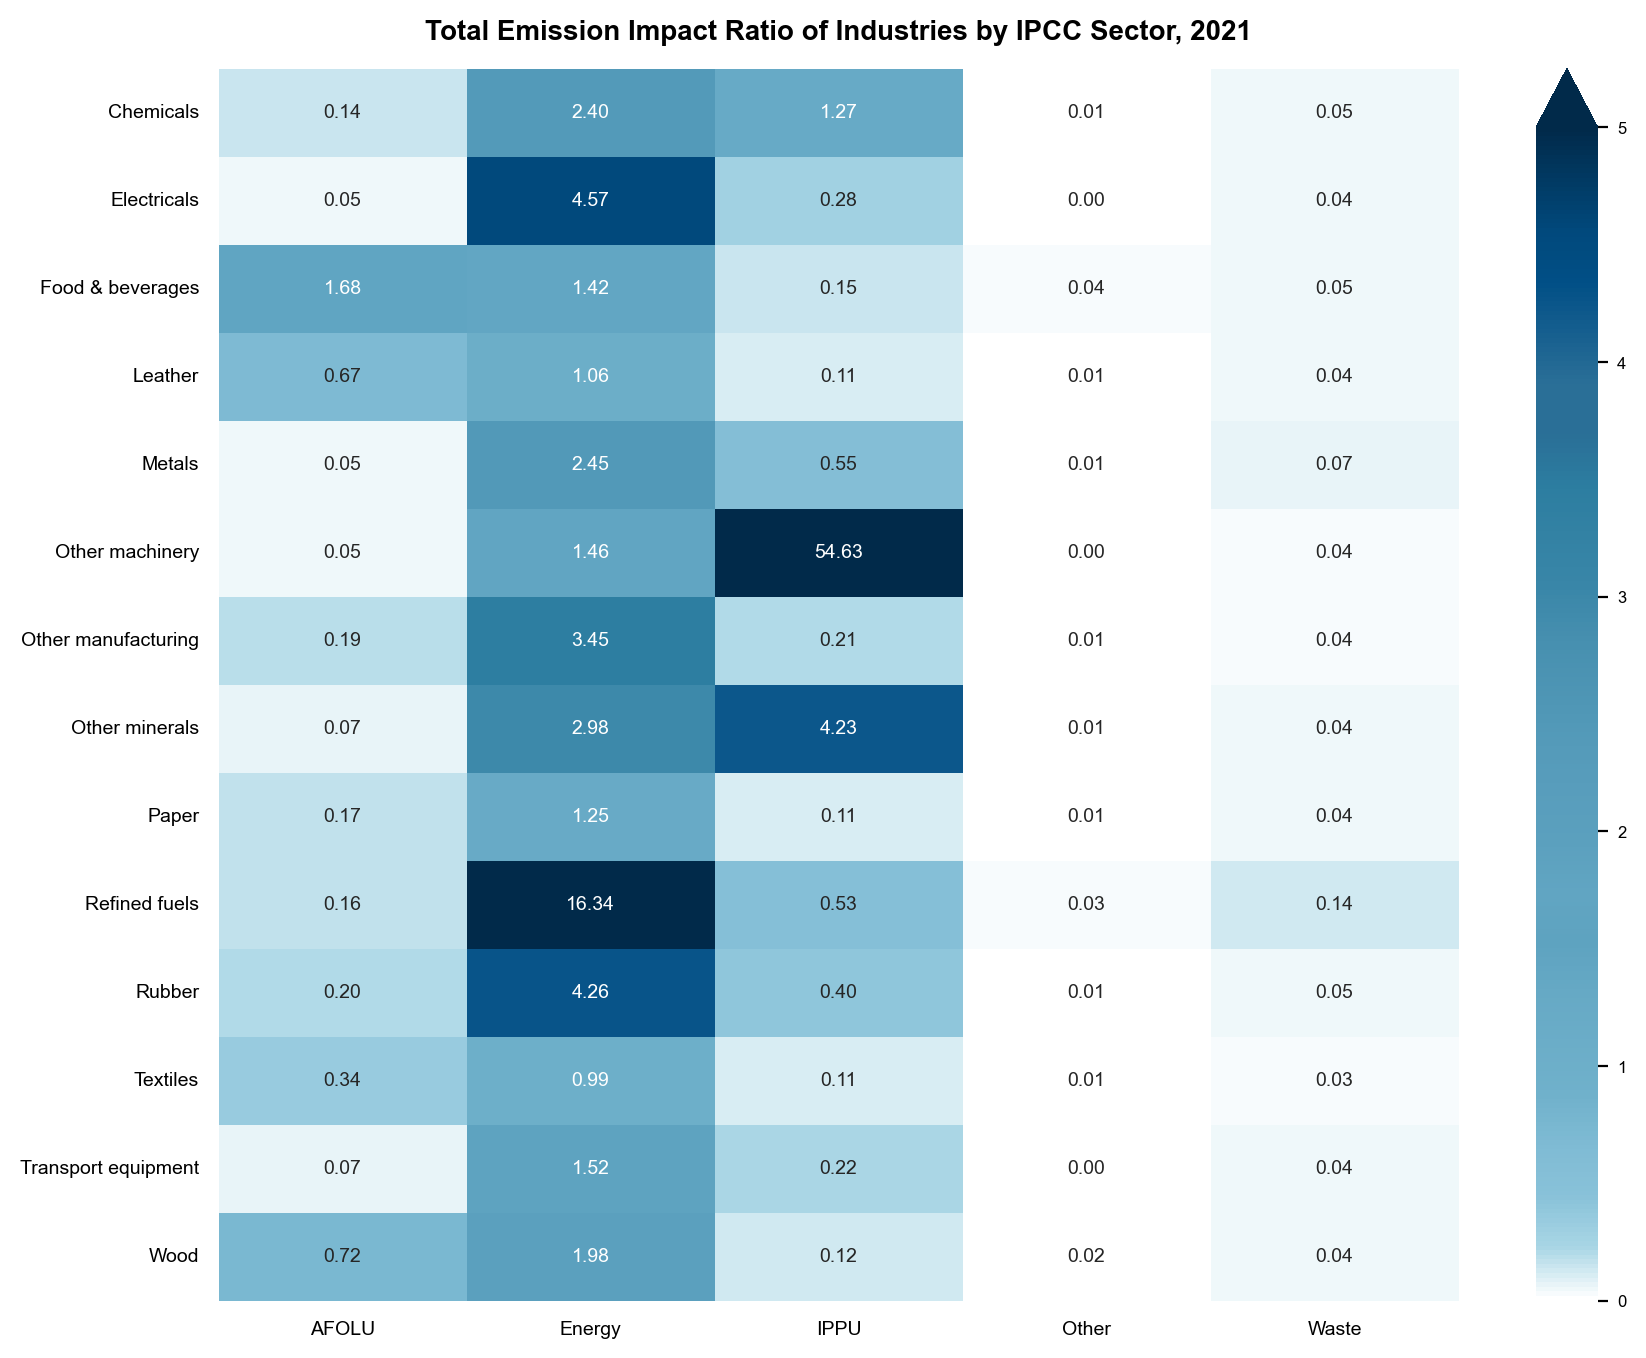

In [501]:
df_heatmap = (
    eir_ipcc[(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='eir',index=['sector_name_short'],columns='ipcc_sector',aggfunc='mean')
)

f, ax = plt.subplots(figsize=(10, 8), dpi=200)

def custom_annot(val):
    return '-' if val == 0 else f'{val:.2f}'
annot_df = df_heatmap.map(custom_annot)

# color palette
heatmap_colors = ['#FFFFFF', '#A9D6E5', '#89C2D9', '#7FBBD4', '#70B1CB', '#6BADC8', '#66A9C5', '#5EA3C0', 
                  '#61A5C2', '#5BA0BE', '#589DBC', '#549AB9', '#4D95B4', '#468FAF', '#3986A8', '#3382A4', 
                  '#2C7DA0', '#2A6F97', '#2A6F97', '#165F8F', '#014F86', '#01497C', '#013A63', '#012A4A']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', heatmap_colors)

sns.heatmap(df_heatmap,annot=annot_df, cmap=custom_cmap, fmt='', vmin=0, vmax=5, ax=ax,
            cbar_kws={'extend': 'max', 'spacing': 'proportional'}, annot_kws={"fontsize": 7})

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)

plt.tick_params(left=False, bottom=False)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('')
plt.ylabel('')
plt.title('Total Emission Impact Ratio of Industries by IPCC Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.savefig('../charts/plot 06.png')
plt.show()

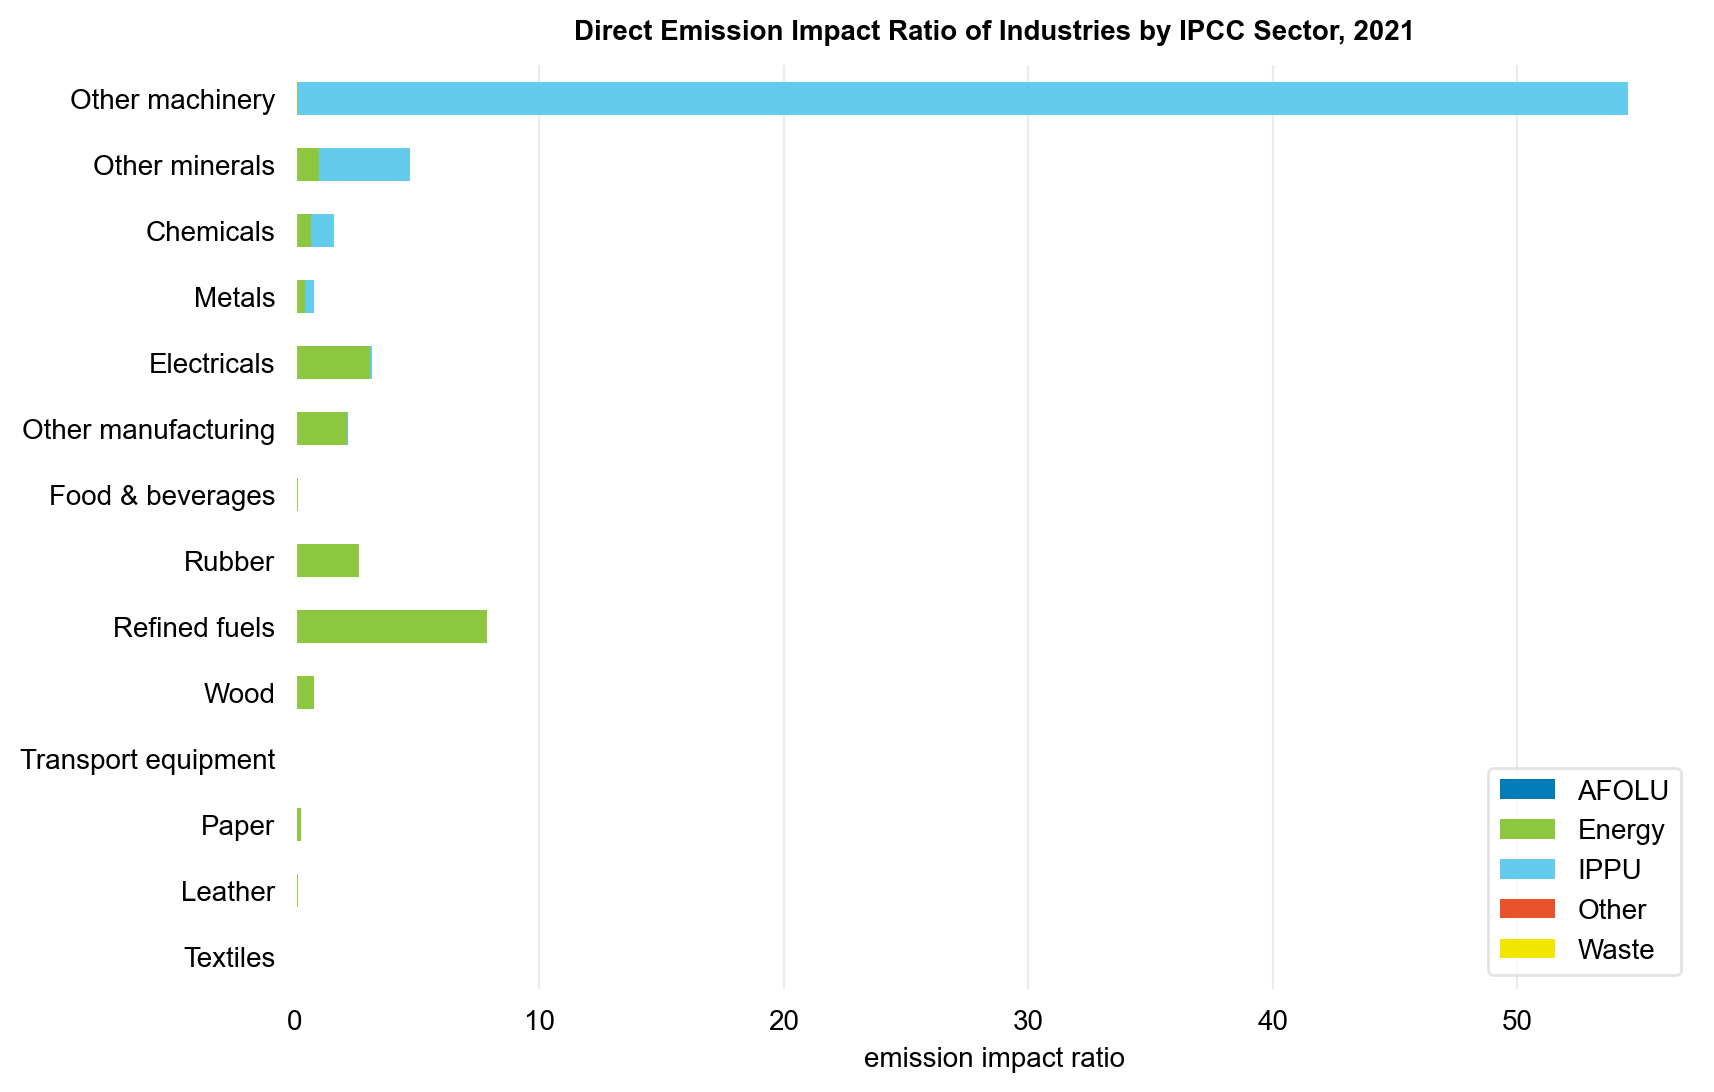

In [503]:
df = (
    eir_ipcc[['sector_name_short', 'ipcc_sector', 'd_eir']]
    [(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='d_eir',index='sector_name_short', columns='ipcc_sector')   
    .sort_values(by='IPPU', ascending=True)
)

f, ax = plt.subplots(figsize=(10, 6), dpi=200)

df.plot(kind='barh', stacked=True, color=['#007db7', '#8dc63f', '#63ccec', '#e9532b', '#f2e600'], ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Direct Emission Impact Ratio of Industries by IPCC Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.subplots_adjust(left=0.2)
 
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)

plt.savefig('../charts/plot 07.png')
plt.show()

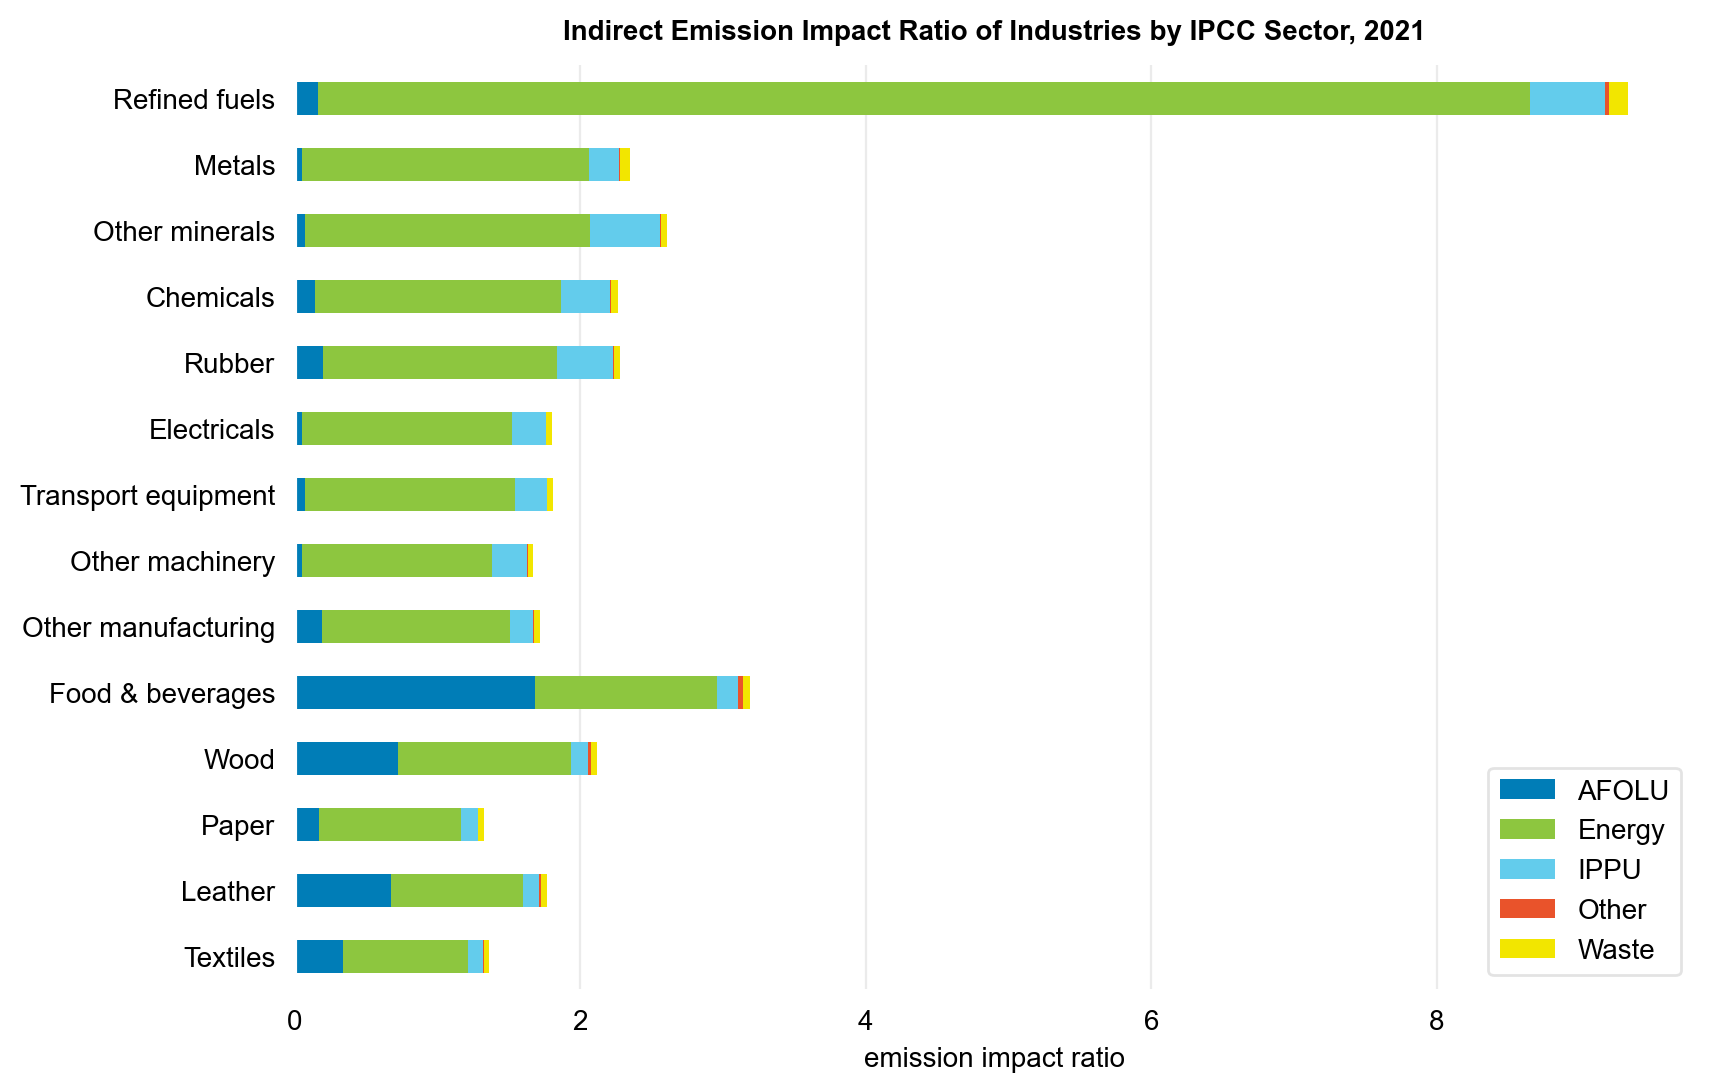

In [505]:
df = (
    eir_ipcc[['sector_name_short', 'ipcc_sector', 'i_eir']]
    [(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='i_eir',index='sector_name_short', columns='ipcc_sector')   
    .sort_values(by='Energy', ascending=True)
)

f, ax = plt.subplots(figsize=(10, 6), dpi=200)

df.plot(kind='barh', stacked=True, color=['#007db7', '#8dc63f', '#63ccec', '#e9532b', '#f2e600'], ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Indirect Emission Impact Ratio of Industries by IPCC Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.subplots_adjust(left=0.2)
 
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)

plt.savefig('../charts/plot 08.png')
plt.show()

##### A.6 Sector: EIR 2017, 2019, 2021

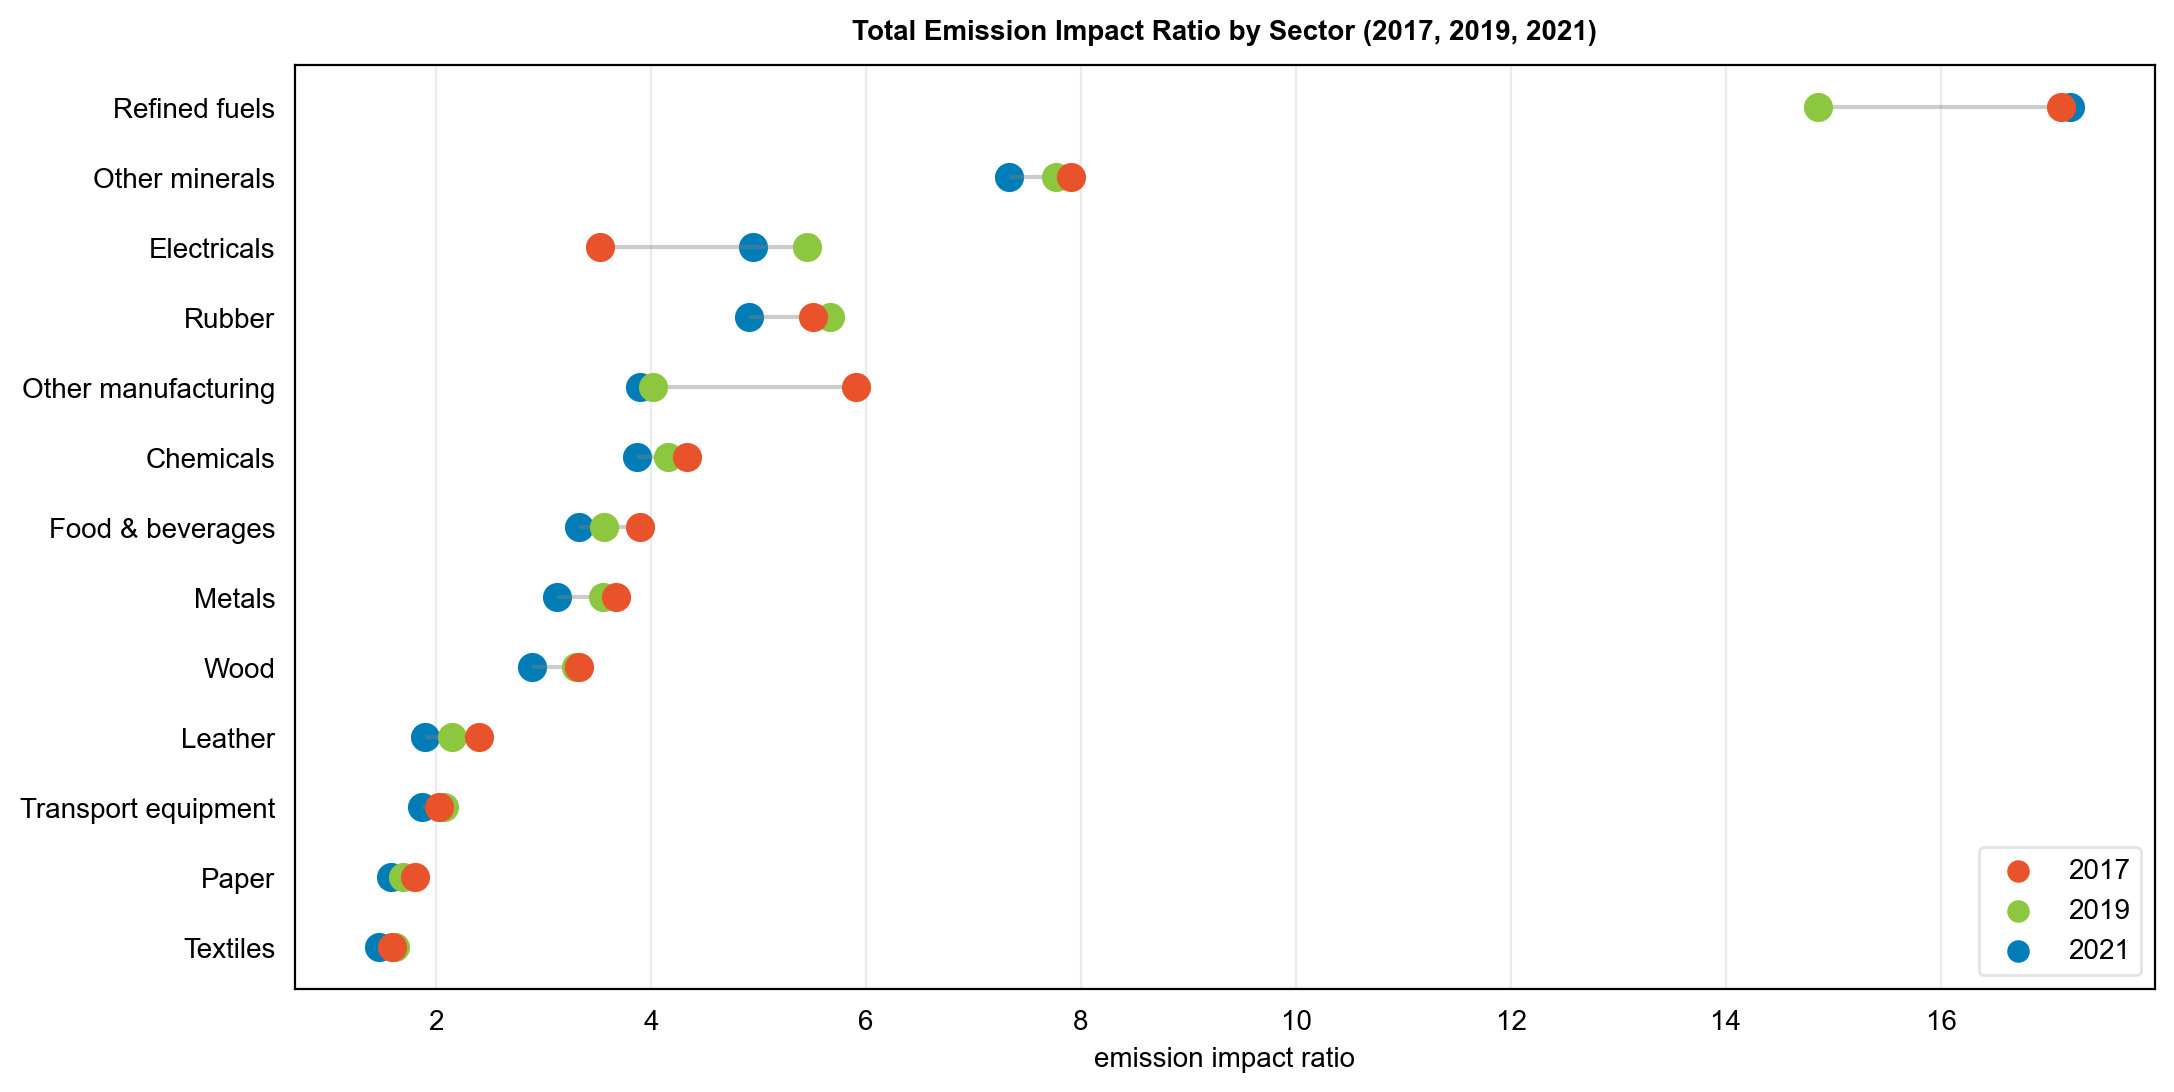

In [205]:
ordered_df = (
    eir_sector[(eir_sector['year'].isin([2017, 2019, 2021])) & (eir_sector['mrio_sector'] != 'c13')]
    .pivot(index=['sector_name', 'sector_name_short'], columns='year', values='eir').reset_index()
    .sort_values(by=2021)
)

plt.figure(figsize=(12, 6), dpi=200, edgecolor='#EBEBEB')

plt.scatter(x=ordered_df[2017], y=ordered_df['sector_name_short'], color='#e9532b', alpha=1, label='2017', s=90, zorder=4)
plt.scatter(x=ordered_df[2019], y=ordered_df['sector_name_short'], color='#8dc63f', alpha=1, label='2019', s=90, zorder=3)
plt.scatter(x=ordered_df[2021], y=ordered_df['sector_name_short'], color='#007db7', alpha=1, label='2021', s=90, zorder=2)

min_val = ordered_df[[2017, 2019, 2021]].min(axis=1)
max_val = ordered_df[[2017, 2019, 2021]].max(axis=1)
plt.hlines(y=ordered_df['sector_name_short'], xmin=min_val, xmax=max_val, color='grey', alpha=0.4)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False)
plt.xlabel('emission impact ratio', fontsize=10, y=-1.01)
plt.ylabel('')
plt.title('Total Emission Impact Ratio by Sector (2017, 2019, 2021)', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 09.png')
plt.show()

### B. Trade Exposure Ratio (TE)
Value of international trade (imports + exports) / value of domestic market (domestic production + imports)
- More global market exposure or presence the more likely it is that there will be foreign subtitute to a sector's product

In [11]:
# process trade data
def get_tedf():

    dfs = []
    for year in years: 
        data_mrio = mrio.MRIO(f'{input_mrio}', year, full=True)

        trade_matrix = data_mrio.Z.zeroout()
        domestic_matrix = data_mrio.Z.zeroout(inverse=True)

        imports = trade_matrix.col_sum().data.reshape(-1,1)
        exports = (trade_matrix.row_sum() + data_mrio.Y.row_sum()).data.reshape(-1,1)
        dom = domestic_matrix.row_sum().data.reshape(-1,1)

        trade = imports + exports
        domestic = imports + dom 
        te = trade / domestic

        te_dict = {
            'year': year,
            'imports': [x for row in imports.tolist() for x in row],
            'exports': [x for row in exports.tolist() for x in row],
            'dom': [x for row in dom.tolist() for x in row],
            'total_trade': [x for row in trade.tolist() for x in row],
            'total_dom': [x for row in domestic.tolist() for x in row],
            'te': [x for row in te.tolist() for x in row]
            } 
        
        # add labels
        temp_df = pd.concat([labels, pd.DataFrame.from_dict(te_dict)], axis=1)
        temp_df = pd.merge(temp_df, sectors_map, on='mrio_sector')
        temp_df = pd.merge(temp_df, region_map, left_on='country', right_on='code').drop(columns=['code'])
        
        # combine dfs 
        dfs.append(temp_df)
        
    te_df = pd.concat(dfs, ignore_index=True)
    return te_df

In [12]:
te_df = get_tedf()
te_df[:5]

,country,mrio_sector,year,imports,exports,dom,total_trade,total_dom,te,sector_no,sector_name,sector_name_short,region
0,AUS,c1,2017,4759.960511,31629.498484,44961.052609,36389.458995,49721.013120,0.731873,1,"Agriculture, hunting, forestry and fishing",Agriculture,East Asia and Pacific
1,AUS,c2,2017,18841.703741,175308.846352,44595.761206,194150.550092,63437.464947,3.060503,2,Mining and quarrying,Mining,East Asia and Pacific
2,AUS,c3,2017,3506.908237,47191.826002,21684.304876,50698.734239,25191.213113,2.012556,3,"Food, beverages and tobacco",Food & beverages,East Asia and Pacific
3,AUS,c4,2017,518.823014,2503.527983,1073.980567,3022.350997,1592.803581,1.897504,4,Textiles and textile products,Textiles,East Asia and Pacific
4,AUS,c5,2017,160.027403,680.611737,149.794737,840.639140,309.822141,2.713296,5,"Leather, leather products and footwear",Leather,East Asia and Pacific


In [32]:
industry_te = te_df[te_df['mrio_sector'].isin(ind_sectors)]

##### B.1 Country: TER of industrial sectors, 2021

In [33]:
te_agg = (
    industry_te
    .drop(columns = ['mrio_sector', 'sector_no', 'sector_name', 'sector_name_short'])
    .groupby(['country', 'year', 'region']).agg('sum')
    .reset_index()
)
te_agg['te'] = te_agg['total_trade'] / te_agg['total_dom']

# TE by year
te_2021 = te_agg[te_agg['year'] == 2021]

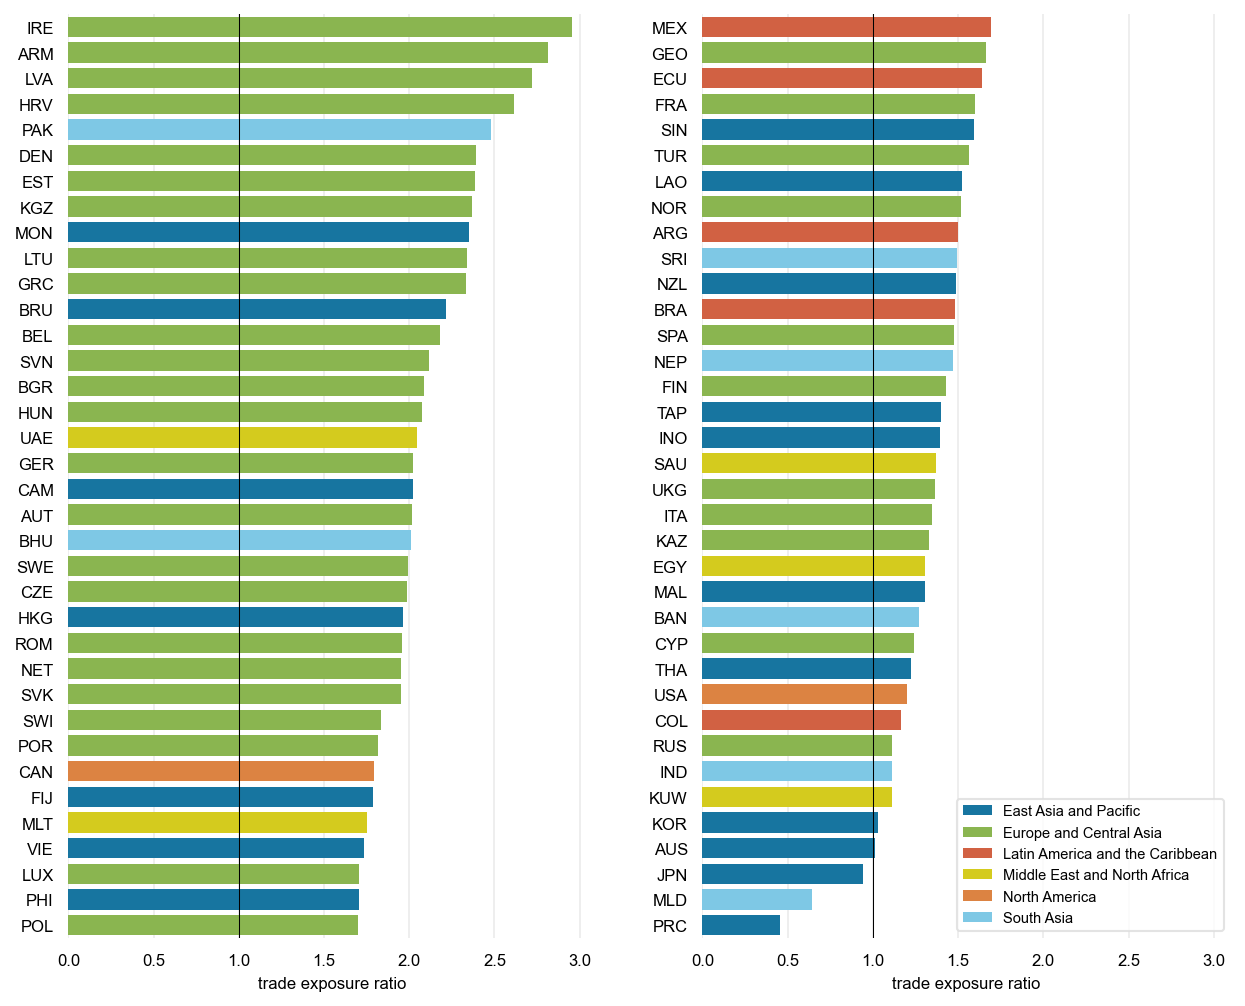

In [273]:
#f, ax = plt.subplots(figsize=(10, 15), dpi=150)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 8), dpi=150)

regions_data = (
    pd.concat([te_2021[te_2021['region'] == region] for region in region_colors])
    .sort_values(by='te', ascending=False)
    )

split = len(regions_data) // 2
x=regions_data['te']
y=regions_data['country']

sns.barplot(x=x[0:split],
            y=y[0:split],
            hue=regions_data['region'][0:split],
            palette=region_colors.values(), 
            hue_order=region_colors.keys(),
            dodge=False, 
            ax=ax1, 
            errorbar=None, 
            zorder=2)

sns.barplot(x=x[split:],
            y=y[split:],
            hue=regions_data['region'][split:],
            palette=region_colors.values(), 
            hue_order=region_colors.keys(),
            dodge=False, 
            ax=ax2, 
            errorbar=None, 
            zorder=2)

for ax in [ax1, ax2]:
    ax.axvline(x=1, color='black', linewidth=0.5)
    ax.grid(axis='x', color='#EBEBEB') 
    ax.tick_params(axis='both', labelsize=8, left=False, bottom=False)
    ax.set_xlabel('trade exposure ratio', fontsize=8)
    ax.set_ylabel('')

legend = ax2.legend(fontsize=7, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
ax1.get_legend().remove()
sns.despine(left=True, bottom=True)

plt.savefig('../charts/plot 10.png')
plt.show()

##### B.2 Sector: TER by industrial sector, 2021

In [34]:
te_sector = (
    te_df[te_df['mrio_sector'].isin(ind_sectors)]
    .drop(columns=['country', 'region'])
    .groupby(['sector_no', 'mrio_sector', 'sector_name', 'sector_name_short', 'year']).agg('mean')
    .reset_index()
    )

te_sector = pd.merge(te_sector, agg_map, left_on='sector_no', right_on='c_ind').drop(columns=['c_ind'])
te_sec_2021 = te_sector[te_sector['year'] == 2021]

In [36]:
te_sec_2021.to_excel('../data/dfs/plot3.xlsx')

In [40]:
agg_colors = {
    'Light manufacturing': '#63ccec',
    'Heavy manufacturing': '#007db7'
}

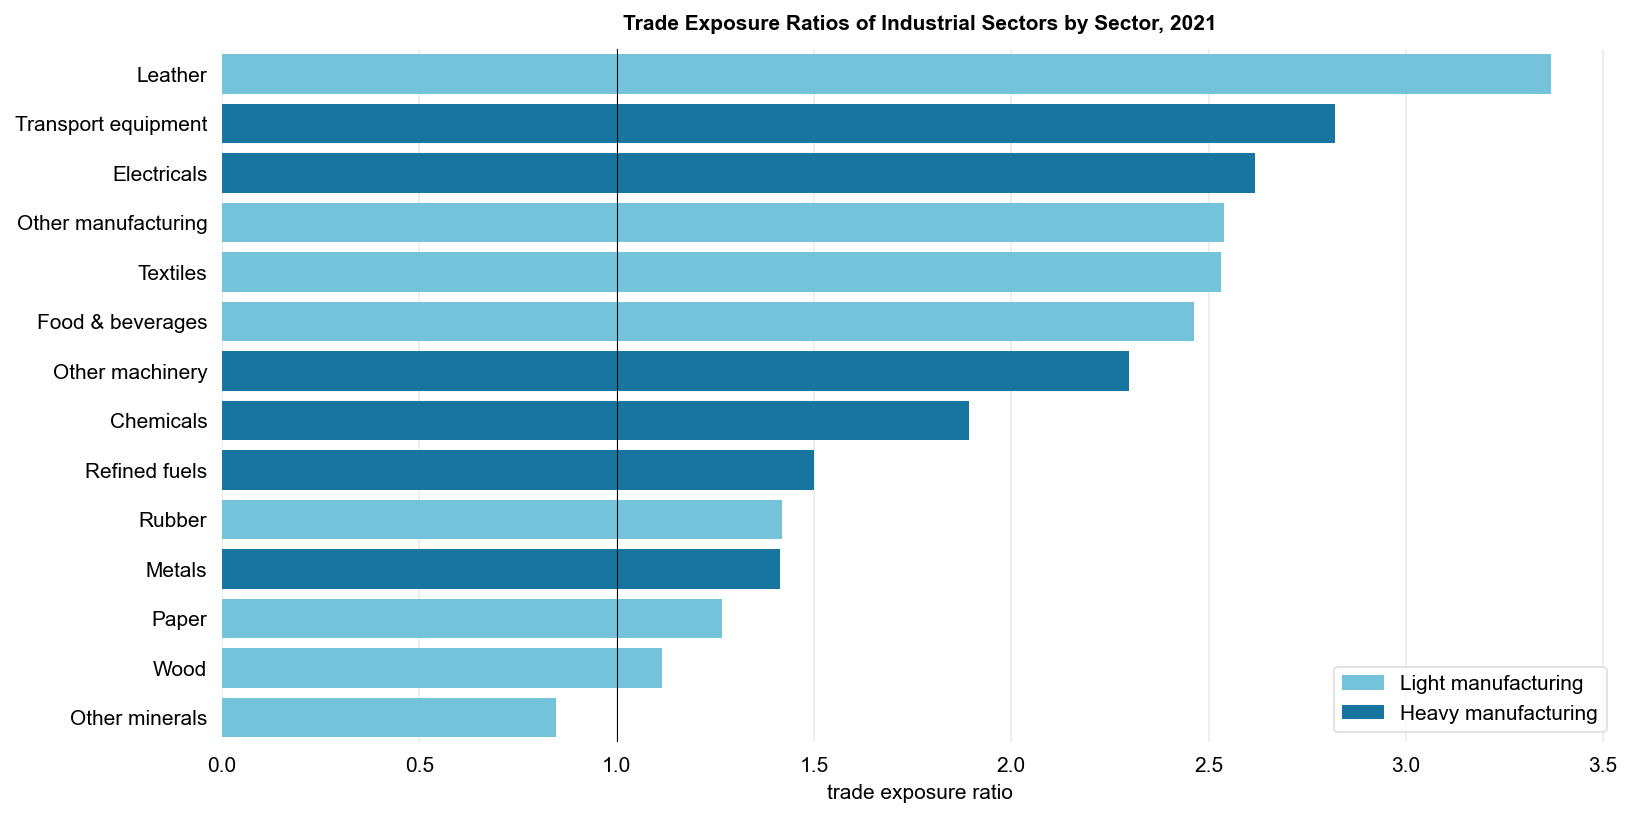

In [41]:
f, ax = plt.subplots(figsize=(12, 6), dpi=150)

agg_data = (
    pd.concat([te_sec_2021[te_sec_2021['c15_name'] == agg] for agg in agg_colors])
    .sort_values(by='te', ascending=False)
    )

sns.barplot(x=agg_data['te'],
            y=agg_data['sector_name_short'],
            hue=agg_data['c15_name'],
            palette=agg_colors.values(), 
            hue_order=agg_colors.keys(),
            dodge=False, 
            ax=ax, 
            errorbar=None, 
            zorder=2)

plt.axvline(x=1, color='black', linewidth=0.5)
plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('trade exposure ratio', fontsize=10)
plt.ylabel('')
plt.title('Trade Exposure Ratios of Industrial Sectors by Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
sns.despine(left=True, bottom=True)

plt.savefig('../charts/plot 11.pdf')
plt.show()

### C. EITE

In [31]:
eite = pd.merge(em_df_total, te_df, on = ['country', 'sector_no', 'mrio_sector', 'year', 'sector_name', 'sector_name_short', 'region'])
eite = pd.merge(eite, sectors_mapping, left_on='sector_no', right_on='c_ind').drop(columns=['c_ind'])

eite['eite'] = eite['eir'] * eite['te']
eite['d_eite'] = eite['d_eir'] * eite['te']
eite['i_eite'] = eite['i_eir'] * eite['te']

eite_2021 = eite[eite['year'] == 2021]

In [68]:
sector_colors = {
    'c6': '#007db7',
    'c7': '#0099d8',
    'c8': '#8dc63f',
    'c9': '#c8da2b',
    'c10': '#68c5ea',
    'c11': '#6dcff6',
    'c12': '#e9532b',
    'c13': '#f57f29',
    #'c14': '#F99A1F',
    'c14': '#fdb515',
    'c15': '#f2e600',
    'c16': '#B1E6F6'
}

lm_colors = {
    'c3': '#007db7',
    'c4': '#63ccec',
    'c5': '#8dc63f',
    'c6': '#c8da2b',
    'c7': '#e9532b',
    'c10': '#f57f29',
    'c11': '#fdb515',
    'c16': '#f2e600'
}

hm_colors = {
    'c8': '#007db7',
    'c9': '#63ccec',
    'c12': '#8dc63f',
    'c13': '#c8da2b',
    'c14': '#e9532b',
    'c15': '#fdb515',
}

sector_colors = {
    'Primary': '#007db7',
    'Low-technology manufacturing': '#63ccec',
    'Medium- to high-technology manufacturing': '#8dc63f',
    'Business services': '#f57f29',
    'Personal and public services': '#fdb515'
}


In [44]:
sample_df = eite_2021[eite_2021['country'].isin(['PRC', 'KOR', 'JPN', 'IND', 'VIE', 'THA'])]

In [33]:
eite_2021 = eite_2021[['mrio_sector', 'c5_name', 'eir', 'te', 'eite']]

In [64]:
eite_ave = (eite_2021
           .groupby(['mrio_sector', 'c5_name'])
           .agg('mean')
           .replace([np.inf, -np.inf], np.nan)
           .dropna()
           .reset_index()
           )

In [65]:
eite_ave

,mrio_sector,c5_name,eir,te,eite
0,c1,Primary,3.194600,1.507829,4.588065
1,c10,Low-technology manufacturing,4.805634,1.465711,7.384895
2,c11,Medium- to high-technology manufacturing,7.207155,0.854237,7.095900
3,c12,Medium- to high-technology manufacturing,3.103583,1.435938,4.293268
4,c13,Medium- to high-technology manufacturing,54.701450,2.297746,282.452586
5,c14,Medium- to high-technology manufacturing,4.833892,2.621173,7.499076
6,c15,Medium- to high-technology manufacturing,1.861943,2.810106,4.889553
7,c16,Low-technology manufacturing,3.813863,2.555560,8.584326
8,c17,Low-technology manufacturing,10.234267,0.901035,8.914260
9,c18,Low-technology manufacturing,1.691487,2.772973,5.187761


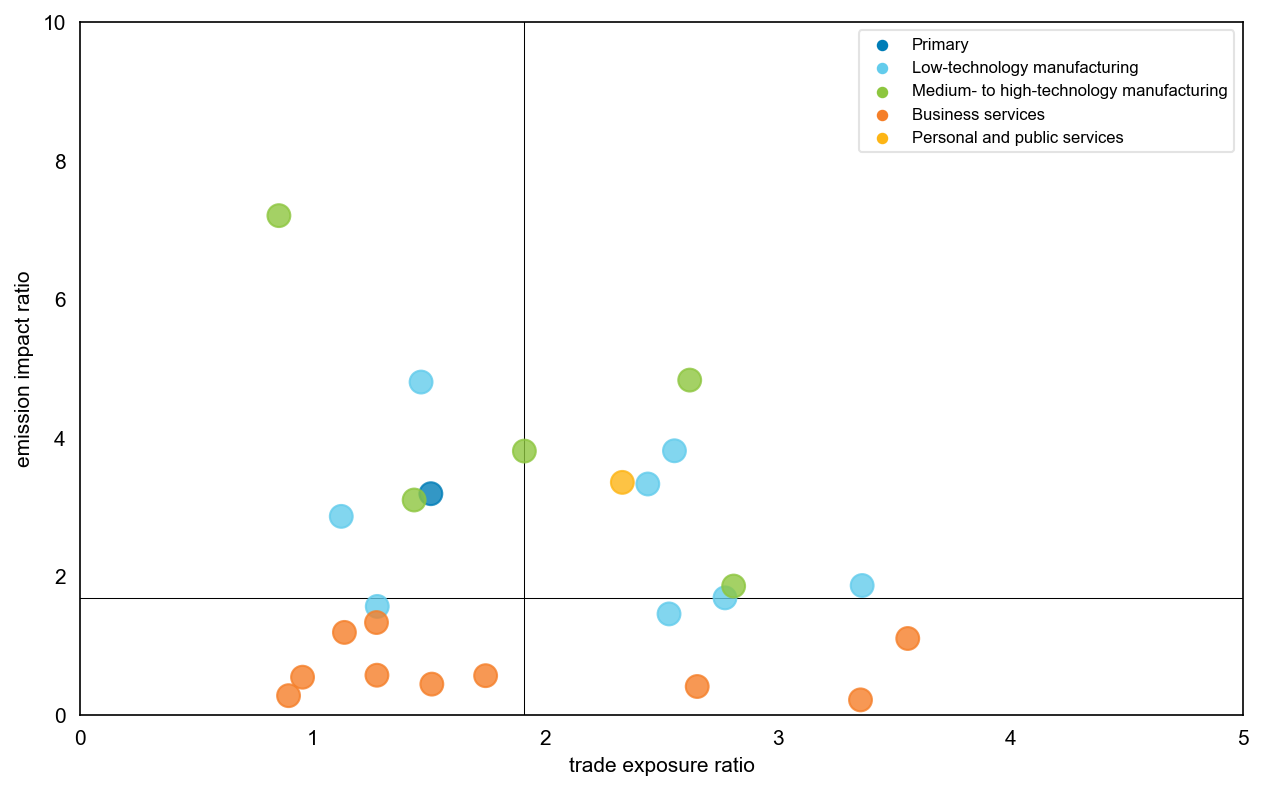

In [72]:
agg_data = (
    pd.concat([eite_ave[eite_ave['c5_name'] == sector] for sector in sector_colors])
    .sort_values(by='eite', ascending=False)
    )
agg_data['color'] = agg_data['c5_name'].map(sector_colors)

plt.figure(figsize=(10, 6), dpi=150, edgecolor='#EBEBEB')
for sector, color in sector_colors.items():
    plt.scatter([], [], color=color, label=sector)  # Creating dummy scatter plot for legend

plt.scatter(x=agg_data['te'], 
            y=agg_data['eir'],
            s=120, 
            alpha=0.8, 
            zorder=2,
            c=agg_data['color']) 

plt.axhline(y=agg_data['eir'].median(), color='black', linewidth=0.5, zorder=0) 
plt.axvline(x=agg_data['te'].median(), color='black', linewidth=0.5, zorder=0) 

plt.xlim((0,5))
plt.ylim((0,10))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('trade exposure ratio', fontsize=10)
plt.ylabel('emission impact ratio', fontsize=10)
#plt.title('Emission Impact and Trade Exposure Ratios of Light Manufacturing Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='upper right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/eite_by_industry.png')
plt.show()

#### C.1 Light manufacturing

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_81703/3170577876.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eite_2021


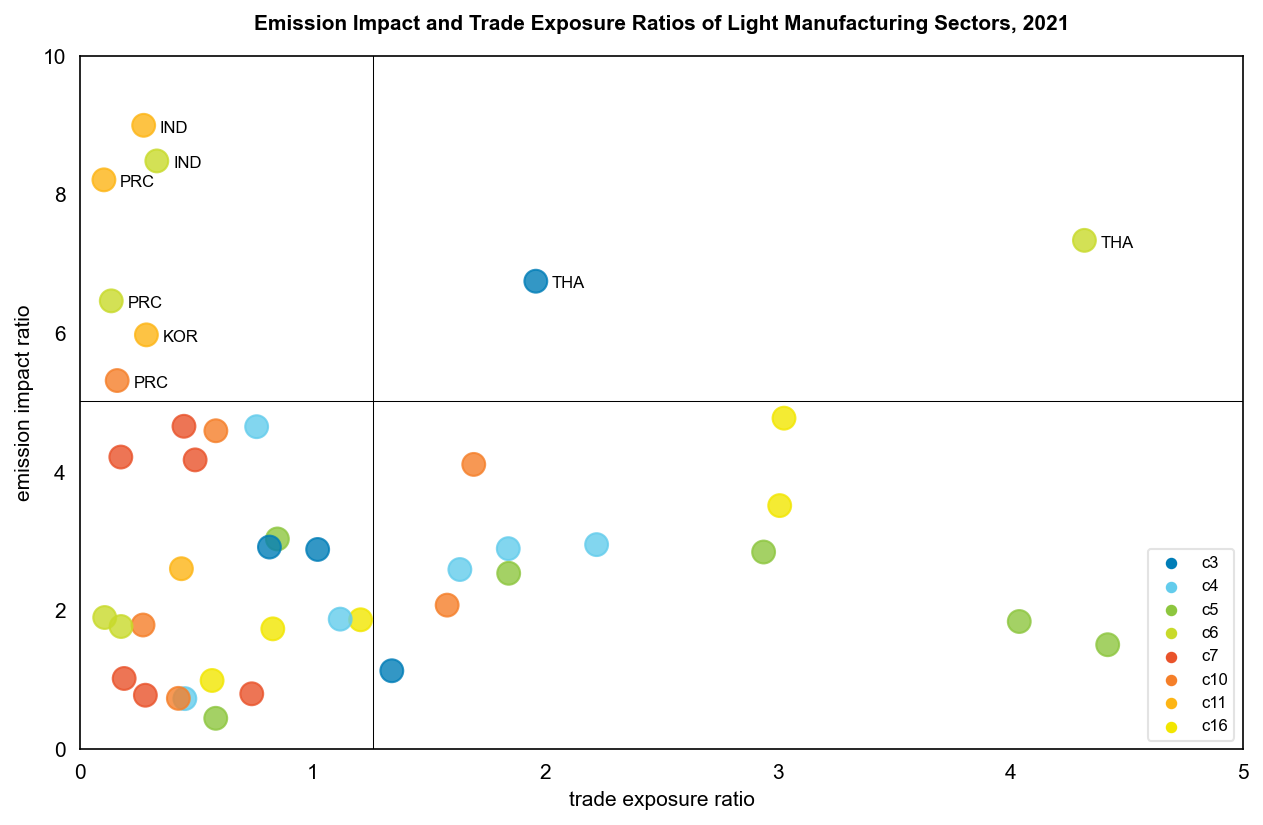

In [45]:
lm_df = (
    eite_2021
    [eite_2021['country']
    .isin(['PRC', 'KOR', 'JPN', 'IND', 'VIE', 'THA'])]
    [eite_2021['c15_name'] == 'Light manufacturing']
     )

agg_data = (
    pd.concat([lm_df[lm_df['mrio_sector'] == sector] for sector in lm_colors])
    .sort_values(by='eite', ascending=False)
    )
agg_data['color'] = agg_data['mrio_sector'].map(lm_colors)

plt.figure(figsize=(10, 6), dpi=150, edgecolor='#EBEBEB')
for sector, color in lm_colors.items():
    plt.scatter([], [], color=color, label=sector)  # Creating dummy scatter plot for legend

plt.scatter(x=agg_data['te'], 
            y=agg_data['eir'],
            s=120, 
            alpha=0.8, 
            zorder=2,
            c=agg_data['color']) 

for i, (x, y) in enumerate(zip(agg_data.te, agg_data.eir)):
    if y > agg_data['eir'].mean():
        plt.annotate(agg_data.country.iloc[i], (x+0.07, y-0.1), fontsize=8)

plt.axhline(y=agg_data['eir'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.axvline(x=agg_data['te'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.xlim((0,5))
plt.ylim((0,10))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('trade exposure ratio', fontsize=10)
plt.ylabel('emission impact ratio', fontsize=10)
plt.title('Emission Impact and Trade Exposure Ratios of Light Manufacturing Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 12.pdf')
plt.show()

In [46]:
lm_df.to_excel('../data/dfs/plot4.xlsx')

#### C.2 Heavy manufacturing

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_81703/666558023.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eite_2021


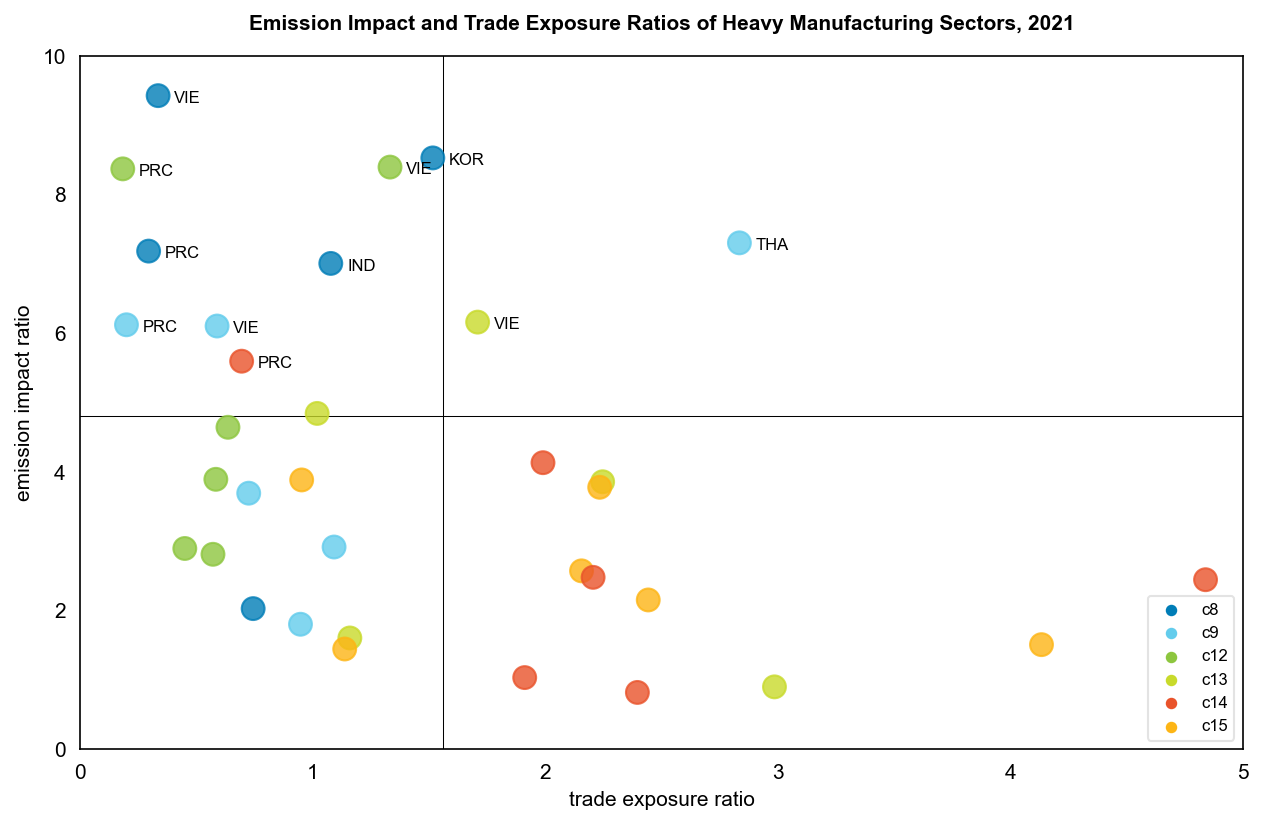

In [48]:
hm_df = (
    eite_2021
    [eite_2021['country']
    .isin(['PRC', 'KOR', 'JPN', 'IND', 'VIE', 'THA'])]
    [eite_2021['c15_name'] == 'Heavy manufacturing']
     )

agg_data = (
    pd.concat([hm_df[hm_df['mrio_sector'] == sector] for sector in hm_colors])
    .sort_values(by='eite', ascending=False)
    )
agg_data['color'] = agg_data['mrio_sector'].map(hm_colors)

plt.figure(figsize=(10, 6), dpi=150, edgecolor='#EBEBEB')
for sector, color in hm_colors.items():
    plt.scatter([], [], color=color, label=sector)  # Creating dummy scatter plot for legend

plt.scatter(x=agg_data['te'], 
            y=agg_data['eir'],
            s=120, 
            alpha=0.8, 
            zorder=2,
            c=agg_data['color']) 

for i, (x, y) in enumerate(zip(agg_data.te, agg_data.eir)):
    if y > agg_data['eir'].mean()+0.5:
        plt.annotate(agg_data.country.iloc[i], (x+0.07, y-0.1), fontsize=8)

plt.axhline(y=agg_data['eir'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.axvline(x=agg_data['te'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.xlim((0,5))
plt.ylim((0,10))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('trade exposure ratio', fontsize=10)
plt.ylabel('emission impact ratio', fontsize=10)
plt.title('Emission Impact and Trade Exposure Ratios of Heavy Manufacturing Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 13.pdf')
plt.show()

In [49]:
lm_df.to_excel('../data/dfs/plot5.xlsx')

#### C.3 Country comparisons

In [52]:
subset_colors = {
    'c8': '#007db7',
    'c10': '#f57f29',
    'c12': '#8dc63f',
    'c13': '#c8da2b',
    'c16': '#f2e600'
}

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_81703/187936091.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.concat([sample_df[sample_df['mrio_sector'] == sector] for sector in subset_colors])


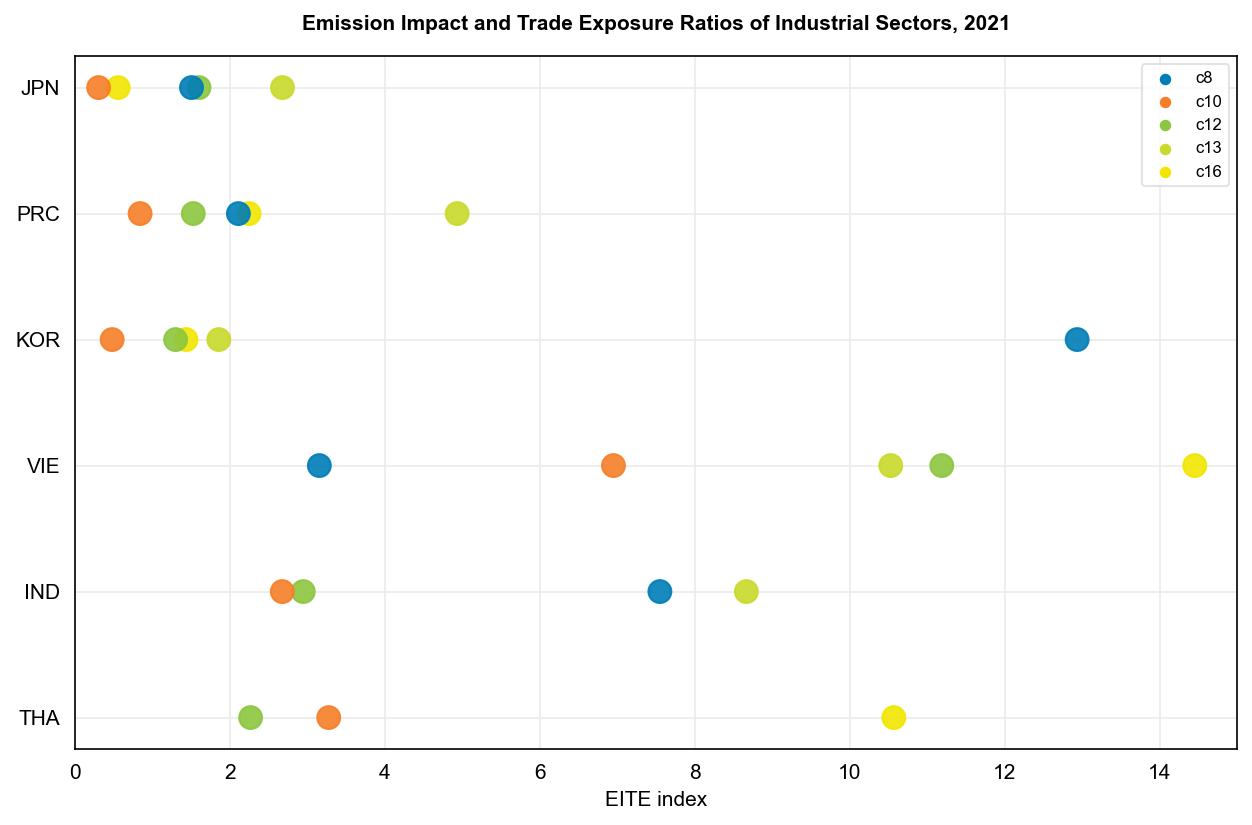

In [55]:
agg_data = (
    pd.concat([sample_df[sample_df['mrio_sector'] == sector] for sector in subset_colors])
    [sample_df['mrio_sector'].isin(['c8', 'c10', 'c12', 'c13', 'c16'])]
    .sort_values(by='eite', ascending=False)
    )
agg_data['color'] = agg_data['mrio_sector'].map(subset_colors)

plt.figure(figsize=(10, 6), dpi=150, edgecolor='#EBEBEB')
for sector, color in subset_colors.items():
    plt.scatter([], [], color=color, label=sector)  # Creating dummy scatter plot for legend

plt.scatter(x=agg_data['eite'], 
            y=agg_data['country'],
            s=120, 
            alpha=0.9, 
            zorder=2,
            c=agg_data['color']) 
 
plt.xlim((0,15))
#plt.ylim((0,5))
plt.grid(color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('EITE index', fontsize=10)
plt.ylabel('')
plt.title('Emission Impact and Trade Exposure Ratios of Industrial Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='upper right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 14.pdf')
plt.show()

In [53]:
sample_df.to_excel('../data/dfs/plot8.xlsx')

#### C.4 Direct: Light manufacturing

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_81703/1670198993.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eite_2021


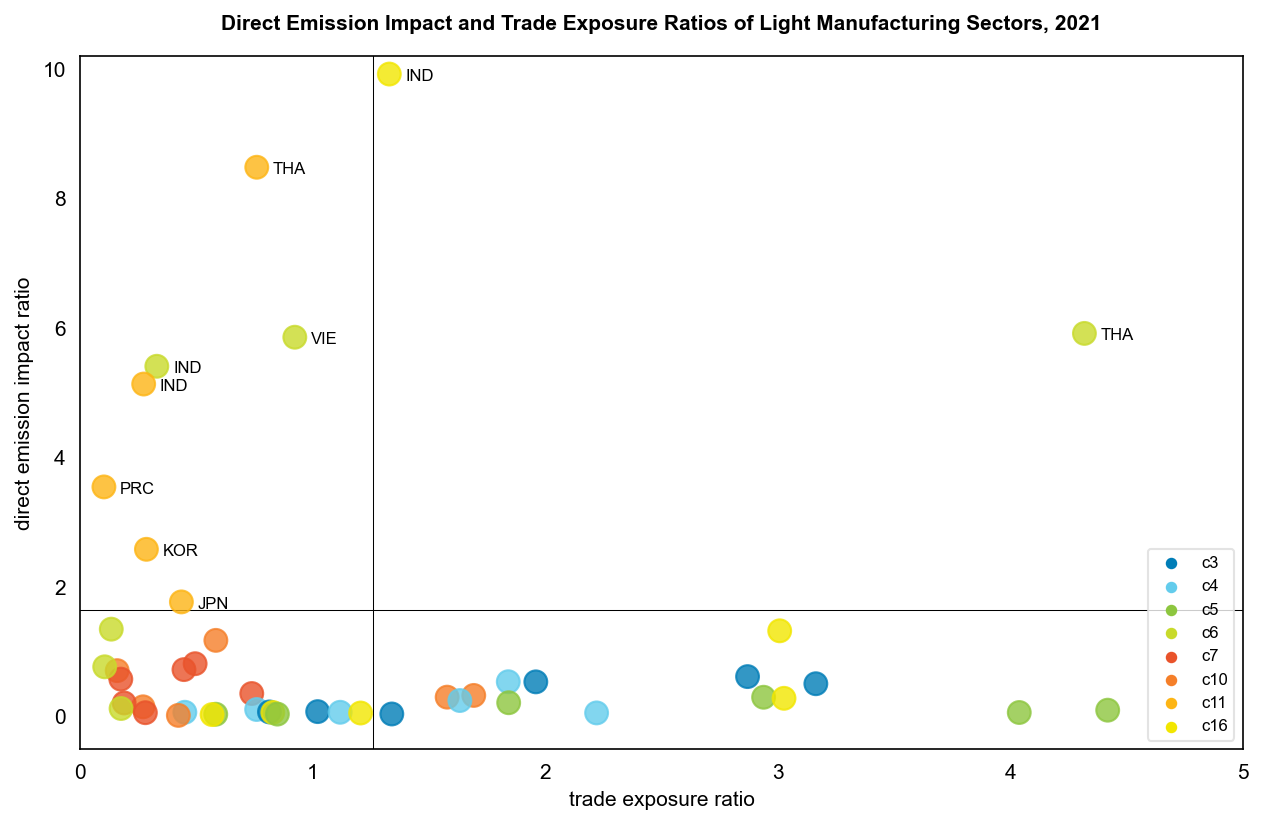

In [50]:
lm_df = (
    eite_2021
    [eite_2021['country']
    .isin(['PRC', 'KOR', 'JPN', 'IND', 'VIE', 'THA'])]
    [eite_2021['c15_name'] == 'Light manufacturing']
     )

agg_data = (
    pd.concat([lm_df[lm_df['mrio_sector'] == sector] for sector in lm_colors])
    .sort_values(by='d_eite', ascending=False)
    )
agg_data['color'] = agg_data['mrio_sector'].map(lm_colors)

plt.figure(figsize=(10, 6), dpi=150, edgecolor='#EBEBEB')
for sector, color in lm_colors.items():
    plt.scatter([], [], color=color, label=sector) 

plt.scatter(x=agg_data['te'], 
            y=agg_data['d_eir'],
            s=120, 
            alpha=0.8, 
            zorder=2,
            c=agg_data['color']) 

for i, (x, y) in enumerate(zip(agg_data.te, agg_data.d_eir)):
    if y > agg_data['d_eir'].mean():
        plt.annotate(agg_data.country.iloc[i], (x+0.07, y-0.1), fontsize=8)

plt.axhline(y=agg_data['d_eir'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.axvline(x=agg_data['te'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.xlim((0,5))
plt.ylim((-0.5,10.2))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('trade exposure ratio', fontsize=10)
plt.ylabel('direct emission impact ratio', fontsize=10)
plt.title('Direct Emission Impact and Trade Exposure Ratios of Light Manufacturing Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 15.pdf')
plt.show()

#### C.5 Direct: Heavy manufacturing

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_81703/2321633070.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eite_2021


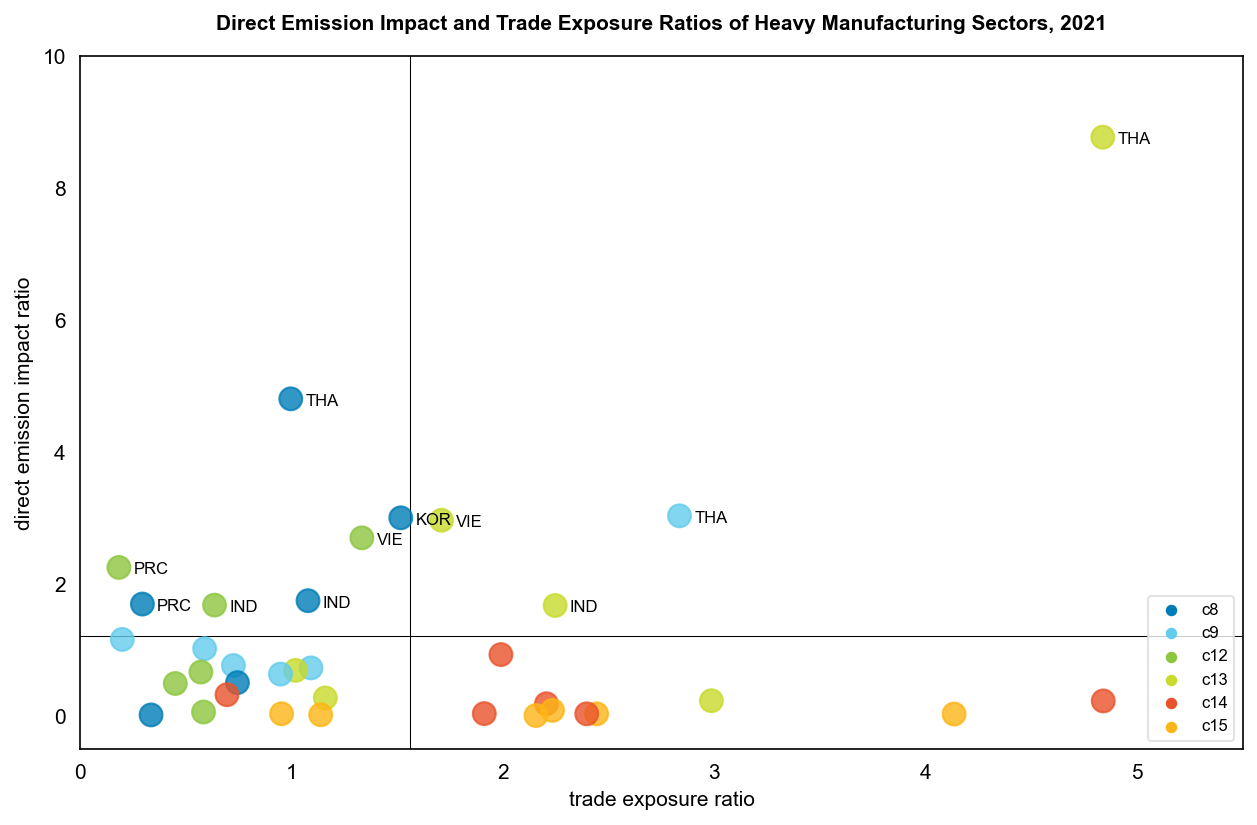

In [51]:
hm_df = (
    eite_2021
    [eite_2021['country']
    .isin(['PRC', 'KOR', 'JPN', 'IND', 'VIE', 'THA'])]
    [eite_2021['c15_name'] == 'Heavy manufacturing']
     )

agg_data = (
    pd.concat([hm_df[hm_df['mrio_sector'] == sector] for sector in hm_colors])
    .sort_values(by='d_eite', ascending=False)
    )
agg_data['color'] = agg_data['mrio_sector'].map(hm_colors)

plt.figure(figsize=(10, 6), dpi=150, edgecolor='#EBEBEB')
for sector, color in hm_colors.items():
    plt.scatter([], [], color=color, label=sector)  # Creating dummy scatter plot for legend

plt.scatter(x=agg_data['te'], 
            y=agg_data['d_eir'],
            s=120, 
            alpha=0.8, 
            zorder=2,
            c=agg_data['color']) 

for i, (x, y) in enumerate(zip(agg_data.te, agg_data.d_eir)):
    if y > agg_data['d_eir'].mean():
        plt.annotate(agg_data.country.iloc[i], (x+0.07, y-0.1), fontsize=8)

plt.axhline(y=agg_data['d_eir'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.axvline(x=agg_data['te'].mean(), color='black', linewidth=0.5, zorder=0) 
plt.xlim((0,5.5))
plt.ylim((-0.5,10))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('trade exposure ratio', fontsize=10)
plt.ylabel('direct emission impact ratio', fontsize=10)
plt.title('Direct Emission Impact and Trade Exposure Ratios of Heavy Manufacturing Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('../charts/plot 16.pdf')
plt.show()

### D. Notes
GDR 2023 
- Chapter (Bo Meng): carbon leakage measurement
- Similar to COVID analysis 
- Emissions (aut) vs emissions (act)